In [142]:
import pdb 
import os 
import pickle 
import json 
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel,ttest_ind, ttest_1samp
import scipy
from matplotlib import pyplot as plt 
import seaborn as sns 
from io import BytesIO
import math 
from sklearn.metrics import adjusted_rand_score 
import requests
import torch as tr
import copy
import random
# humanUtils
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/humanUtils.py")
with open('humanUtils.py', 'w') as f:
    f.write(r.text)
from humanUtils import * 
# analysis
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/analysis.py")
with open('analysis.py', 'w') as f:
    f.write(r.text)
from analysis import *
# utils 
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/utils.py")
with open('utils.py', 'w') as f:
    f.write(r.text)
from utils import * 

plt.rcParams['font.size'] = 22

# constants for plot making

In [143]:
cLD = {
  'blocked': ['green','blue', 'green','blue', 'red'],
  'blocked_rep': ['green','blue', 'green','blue', 'red'],
  'interleaved': ['gold','gold','gold','gold','red'],
  'interleaved_rep': ['gold','gold','gold','gold','red'],
  'inserted_early': ['blue','green','gold','gold','red'],
  'early': ['blue','green','gold','gold','red'],
  'inserted_early_rep': ['blue','green','gold','gold','red'],
  'inserted_middle': ['gold','blue','green','gold','red'],
  'middle': ['gold','blue','green','gold','red'],
  'inserted_middle_rep': ['gold','blue','green','gold','red'],
  'inserted_late': ['gold','gold','blue','green','red'],
  'late': ['gold','gold','blue','green','red'],
  'inserted_late_rep': ['gold','gold','blue','green','red'],
  'explicit_interleaved': ['purple','purple','purple','purple','red'],
}

TITLES_ON = False
condL = ['blocked','interleaved','early','middle','late']
fig_save_path = "figures/"

# human dataframe

## load and save dataframes from each experiemnt

In [144]:
## load and save
dfD = {}
for cond in ALL_CONDITIONS:
  for thresh in [0.9,0]:
    fname = f"{cond}_thresh{int(thresh*100)}.csv"
    df = pd.read_csv(f'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/{fname}')
    dfD[cond,thresh] = df   
human_df = pd.concat(dfD,names=['condition','thresh'])

## additional formating to human df

In [145]:
# additional columns
human_df.loc[:,'score'] = human_df.correct_response
human_df.loc[:,'response_node'] = human_df.apply(lambda r: [r.false_tonode,r.true_tonode][r.correct_response],axis=1)
node2stateD = {
  "BEGIN":0,
  "LOCNODEB":1,
  "LOCNODEC":2,
  "NODE11":3,
  "NODE12":4,
  "NODE21":5,
  "NODE22":6,
  "NODE31":7,
  "NODE32":8,
  "END":9
}
human_df.loc[:,'rfc_int'] = (human_df.true_rfc.str.split('-').str[-1].str.lower()=='jungle').astype('int')
human_df.loc[:,'response_node_int'] = human_df.apply(lambda r: node2stateD[r.response_node],axis=1)
# finalize
human_df = human_df
print(human_df.columns)
human_df.head()



Index(['subjnum', 'block', 'story', 'depth', 'Unnamed: 4', 'type', 'qtype',
       'state', 'fromnode', 'true_tonode', 'false_tonode', 'rfc', 'true_rfc',
       'false_rfc', 'response_right', 'true_on_right', 'correct_response',
       'edge', 'score', 'response_node', 'rfc_int', 'response_node_int'],
      dtype='object')


subjnum  block  story  depth  Unnamed: 4      type  \
condition thresh                                                         
blocked   0.9    0        6      0      0      1          11  question   
                 1        6      0      0      2          15  question   
                 2        6      0      1      1          30  question   
                 3        6      0      1      2          34  question   
                 4        6      0      2      1          49  question   

                     qtype  state fromnode true_tonode  ...  \
condition thresh                                        ...   
blocked   0.9    0  transQ    NaN   NODE11      NODE22  ...   
                 1  transQ    NaN   NODE22      NODE31  ...   
                 2  transQ    NaN   NODE11      NODE22  ...   
                 3  transQ    NaN   NODE22      NODE31  ...   
                 4  transQ    NaN   NODE11      NODE22  ...   

                                           true_rfc  \
condition thresh                                      
blocked   0.9    0  subject-Beverly_location-jungle   
                 1  subject-Beverly_location-jungle   
                 2    subject-Jacob_location-jungle   
                 3    subject-Jacob_location-jungle   
                 4   subject-Denise_location-jungle   

                                          false_rfc response_right  \
condition thresh                                                     
blocked   0.9    0  subject-Beverly_location-jungle           True   
                 1  subject-Beverly_location-jungle           True   
                 2    subject-Jacob_location-jungle           True   
                 3    subject-Jacob_location-jungle           True   
                 4   subject-Denise_location-jungle           True   

                   true_on_right  correct_response          edge  score  \
condition thresh                                                          
blocked   0.9    0         False                 0  NODE11NODE22      0   
                 1         False                 0  NODE22NODE31      0   
                 2          True                 1  NODE11NODE22      1   
                 3          True                 1  NODE22NODE31      1   
                 4          True                 1  NODE11NODE22      1   

                   response_node  rfc_int response_node_int  
condition thresh                                             
blocked   0.9    0        NODE21        1                 5  
                 1        NODE32        1                 8  
                 2        NODE22        1                 6  
                 3        NODE31        1                 7  
                 4        NODE22        1                 6  

[5 rows x 22 columns]

# plots organized by flow

In [146]:

human_df.query("condition==['blocked_rep']&thresh==0.9").reset_index()#.subjnum.unique()

condition  thresh  level_2  subjnum  block  story  depth  Unnamed: 4  \
0     blocked_rep     0.9        0        0      0      0      1           9   
1     blocked_rep     0.9        1        0      0      1      2          30   
2     blocked_rep     0.9        2        0      0      2      1          45   
3     blocked_rep     0.9        3        0      0      2      2          49   
4     blocked_rep     0.9        4        0      0      3      2          68   
...           ...     ...      ...      ...    ...    ...    ...         ...   
7747  blocked_rep     0.9     7747       60      4    197      1        3594   
7748  blocked_rep     0.9     7748       60      4    197      2        3598   
7749  blocked_rep     0.9     7749       60      4    198      1        3611   
7750  blocked_rep     0.9     7750       60      4    198      2        3615   
7751  blocked_rep     0.9     7751       60      4    199      2        3632   

          type   qtype  ...                        true_rfc  \
0     question  transQ  ...     subject-Diana_location-deep   
1     question  transQ  ...     subject-Peter_location-deep   
2     question  transQ  ...   subject-Cynthia_location-deep   
3     question  transQ  ...   subject-Cynthia_location-deep   
4     question  transQ  ...      subject-Kyle_location-deep   
...        ...     ...  ...                             ...   
7747  question  transQ  ...  subject-Justin_location-jungle   
7748  question  transQ  ...  subject-Justin_location-jungle   
7749  question  transQ  ...      subject-Noah_location-deep   
7750  question  transQ  ...      subject-Noah_location-deep   
7751  question  transQ  ...  subject-Lawrence_location-deep   

                           false_rfc response_right true_on_right  \
0        subject-Diana_location-deep          False          True   
1        subject-Peter_location-deep           True          True   
2      subject-Cynthia_location-deep          False         False   
3      subject-Cynthia_location-deep          False         False   
4         subject-Kyle_location-deep          False          True   
...                              ...            ...           ...   
7747  subject-Justin_location-jungle          False         False   
7748  subject-Justin_location-jungle          False         False   
7749      subject-Noah_location-deep          False         False   
7750      subject-Noah_location-deep           True          True   
7751  subject-Lawrence_location-deep           True          True   

      correct_response          edge score  response_node  rfc_int  \
0                    0  NODE12NODE22     0         NODE21        0   
1                    1  NODE21NODE31     1         NODE31        0   
2                    1  NODE12NODE22     1         NODE22        0   
3                    1  NODE22NODE32     1         NODE32        0   
4                    0  NODE22NODE32     0         NODE31        0   
...                ...           ...   ...            ...      ...   
7747                 1  NODE11NODE22     1         NODE22        1   
7748                 1  NODE22NODE31     1         NODE31        1   
7749                 1  NODE11NODE21     1         NODE21        0   
7750                 1  NODE21NODE31     1         NODE31        0   
7751                 1  NODE22NODE32     1         NODE32        0   

      response_node_int  
0                     5  
1                     7  
2                     6  
3                     8  
4                     7  
...                 ...  
7747                  6  
7748                  7  
7749                  5  
7750                  7  
7751                  8  

[7752 rows x 25 columns]

In [227]:
def lineplt_single(cond,thresh,transition=None,ax=None,fgkw={},figname="none"):
  
  plt.figure(figsize=(12,8))
  condL=[cond]
  if not ax:
    ax = plt.gca()
  df_plt = human_df.query("condition==@condL&thresh==@thresh").reset_index()
  print(df_plt.thresh.unique())
  if transition:
    assert transition in [1,2]
    df_plt = df_plt.query(f"depth=={transition}")
  g = sns.lineplot(data=df_plt,x='story',y='score',ax=ax,**fgkw)
  fsize = 45
  ax.axhline(0.5,c='k')
  ax.set_ylabel('prediction accuracy', fontsize = fsize)
  ax.set_xlabel('trial', fontsize = fsize)
  ax.set_xticks([0,25,50,75,100,125,150,175,200]) 
  ax.set_yticks([0.0, 0.2,0.4,0.6,0.8,1.0])
  ax.tick_params(axis='x', labelsize=fsize - 10)
  ax.tick_params(axis='y', labelsize=fsize - 10)
  # background color
  color_background(ax,cond)
  if TITLES_ON:
    ax.set_title("cond=%s-filter=%.2f-transition=%s"%(cond,thresh,transition))
  return g



def color_background(ax,cond):
  for idx in range(5):
      ax.fill_between(
        np.arange(40*idx,41+40*idx),
        0,1.05,
        color=cLD[cond][idx],
        alpha=0.2
    )

def lineplt(condL,thresh,transition=None,ax=None,fgkw={},figname="none"):
  for cond in condL:
    lineplt_single(cond,thresh,transition=transition,ax=ax,fgkw=fgkw,figname=figname)

def beetestplt(condL,thresh,transition=None,figname="none"):
  
  plt.figure(figsize=(12,8))
  ax = plt.gca()
  df_plt = human_df.query(f"condition==@condL&thresh==@thresh").reset_index()
  if transition:
    assert transition in [1,2]
    df_plt = df_plt.query(f"depth=={transition}")
  dftest_plt = df_plt.query("block==4")
  g = sns.violinplot(data=dftest_plt.groupby(['subjnum','condition']).mean().reset_index(),
                x='condition',y='score',hue_order='condition',ax=ax,order=condL
               )

  fsize = 45
  ax.set_ylabel('prediction accuracy', fontsize = fsize) 
  ax.set_xlabel('condition', fontsize = fsize)
  ax.tick_params(axis='x', labelsize=fsize - 10)
  ax.tick_params(axis='y', labelsize=fsize - 10)
  if TITLES_ON:
    ax.set_title("cond=%s-filter=%.2f-transition=%s"%(cond,thresh,transition))
  return g

### Figure 2

In [148]:
# set up LSTM
class CSWNet(tr.nn.Module):
  def __init__(self,lstm_hidden_layer_size,seed):
    super().__init__()
    tr.manual_seed(seed)
    self.seed = seed
    self.lstm_hidden_layer_size = lstm_hidden_layer_size
    self.smdim = 9
    self.input_embed = tr.nn.Embedding(self.smdim,self.lstm_hidden_layer_size)
    self.lstm = tr.nn.LSTMCell(self.lstm_hidden_layer_size,self.lstm_hidden_layer_size)
    self.init_lstm = tr.nn.Parameter(tr.rand(2,1,self.lstm_hidden_layer_size),requires_grad=True)
    self.ff_hid2ulog = tr.nn.Linear(self.lstm_hidden_layer_size,self.smdim,bias=False)
    return None
  def forward(self,state_int):
    state_emb = self.input_embed(state_int)
    h_lstm,c_lstm = self.init_lstm
    outputs = -tr.ones(len(state_emb),self.lstm_hidden_layer_size)
    for tstep in range(len(state_emb)):
      h_lstm,c_lstm = self.lstm(state_emb[tstep],(h_lstm,c_lstm))
      outputs[tstep] = h_lstm
    outputs = self.ff_hid2ulog(outputs)
    return outputs
class CSWSchema():
  def __init__(self,AorB):
    self.end_node = 0
    self.graph = self.get_graph(AorB)
  def get_graph(self,schemaAorB):
    if schemaAorB == "A":
      graph = {
        1:{3:0.5, 4:0.5},
        3:{5:1, 6:0},
        4:{5:0, 6:1},
        5:{7:1, 8:0},
        6:{7:0,8:1},
        7:{0:1.0},
        8:{0:1.0}
      }
    elif schemaAorB == "B":
      graph = {
        2:{3:0.5, 4:0.5},
        3:{5:0, 6:1},
        4:{5:1, 6:0},
        5:{7:0, 8:1},
        6:{7:1,8:0},
        7:{0:1.0},
        8:{0:1.0}
      }
    return graph
  def sample_path(self, schemaAorB):
    path = []
    frnode = 1 if schemaAorB == "A" else 2
    while frnode!= self.end_node:
      path.append(frnode)
      distr = self.graph[frnode]
      tonodes = list(distr.keys())
      pr = list(distr.values())
      frnode = np.random.choice(tonodes,p=pr)
    path.append(self.end_node)
    return np.array(path)
  def dataset_processed(self,path):
    X = path[0:-2]
    Y = path[1:-1]
    X = np.vstack([X]).transpose()
    Y = np.vstack([Y]).transpose()
    Y = tr.LongTensor(Y)
    X = tr.tensor(X) # int tensor
    return X,Y
  def format_Xeval(self,pathL):
    """
    given a list of paths [[0,1,3,5],[0,2,3,6]]
    returns an array with format expected by Trainer.predict_step
      (num_samples,depth,in_len)
    """
    Xeval = np.array(pathL)
    Xeval = np.expand_dims(Xeval,2)
    return Xeval

In [149]:
# train or read in precomputed results for exact figure replication
exact_figure = True
if exact_figure:
  print("exact figure replication")
  r = requests.get('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/condition_to_softmax_evaluation.json')
  condition_to_softmax_evaluation = r.json()
  for key,value in condition_to_softmax_evaluation.items():
    condition_to_softmax_evaluation[key] = np.array(value)
else:
  num_seeds = 10
  lstm_hidden_layer_size = 200
  learning_rate = 0.08
  num_stories = 200
  schema_list = [CSWSchema("A"),CSWSchema("B")]
  schema_id_list = ["A", "B"]
  schema_changer = 0
  current_schema, current_schema_id = schema_list[schema_changer], schema_id_list[schema_changer]
  evaluate_path_list = [[1,3,5], [2,3,6]]
  xeval = schema_list[0].format_Xeval(evaluate_path_list)
  xeval = tr.tensor(xeval)
  condition_to_softmax_evaluation = {}
  for blocked_or_interleaved in ["blocked", "interleaved"]:
    print(blocked_or_interleaved)
    # initialize variables for training and evaluation
    softmax = lambda ulog: tr.softmax(ulog,-1)
    lossop = tr.nn.CrossEntropyLoss()
    acc = -np.ones([num_seeds,num_stories])
    tdim,sm_dim=3,9
    ysm = -np.ones([num_seeds,2,num_stories,tdim,sm_dim])
    # train each seed
    for seed in range(num_seeds):
      lossL = []
      # init neural network
      net = CSWNet(lstm_hidden_layer_size,seed)
      optiop = tr.optim.Adam(net.parameters(), lr=learning_rate)
      schema_changer = 0
      repeat_schema_length = 40 if blocked_or_interleaved == "blocked" else 1
      for story_num in range(num_stories):
        # set to interleaved during testing trials
        if story_num >= 160:
          repeat_schema_length = 1
        # select current schema
        if (story_num%repeat_schema_length)==0:
          schema_changer = (schema_changer+1)%2
          current_schema = schema_list[schema_changer]
          current_schema_id = schema_id_list[schema_changer]
        # forward
        path = current_schema.sample_path(current_schema_id)
        xtrain,ytrain = current_schema.dataset_processed(path)
        #pdb.set_trace()
        yh = net(xtrain) # (time,smunits)
        yh_sm = softmax(yh).detach().numpy()
        yt = ytrain.detach().numpy().squeeze()
        acc[seed,story_num] = np.mean(np.equal(np.argmax(yh_sm[1:2],1),yt[1:2]))
        # evaluate other schema without propogating error (freezing)
        for idx,xev in enumerate(xeval):
          ysm_t = softmax(net(xev)).detach().numpy()
          ysm[seed,idx,story_num] = ysm_t
        # backpropogation
        loss = 0
        for tstep in range(len(xtrain)):
          loss += lossop(yh[tstep].unsqueeze(0),ytrain[tstep])
        optiop.zero_grad()
        loss.backward(retain_graph=True)
        optiop.step()
        lossL.append(loss)
    condition_to_softmax_evaluation[blocked_or_interleaved] = ysm

exact figure replication


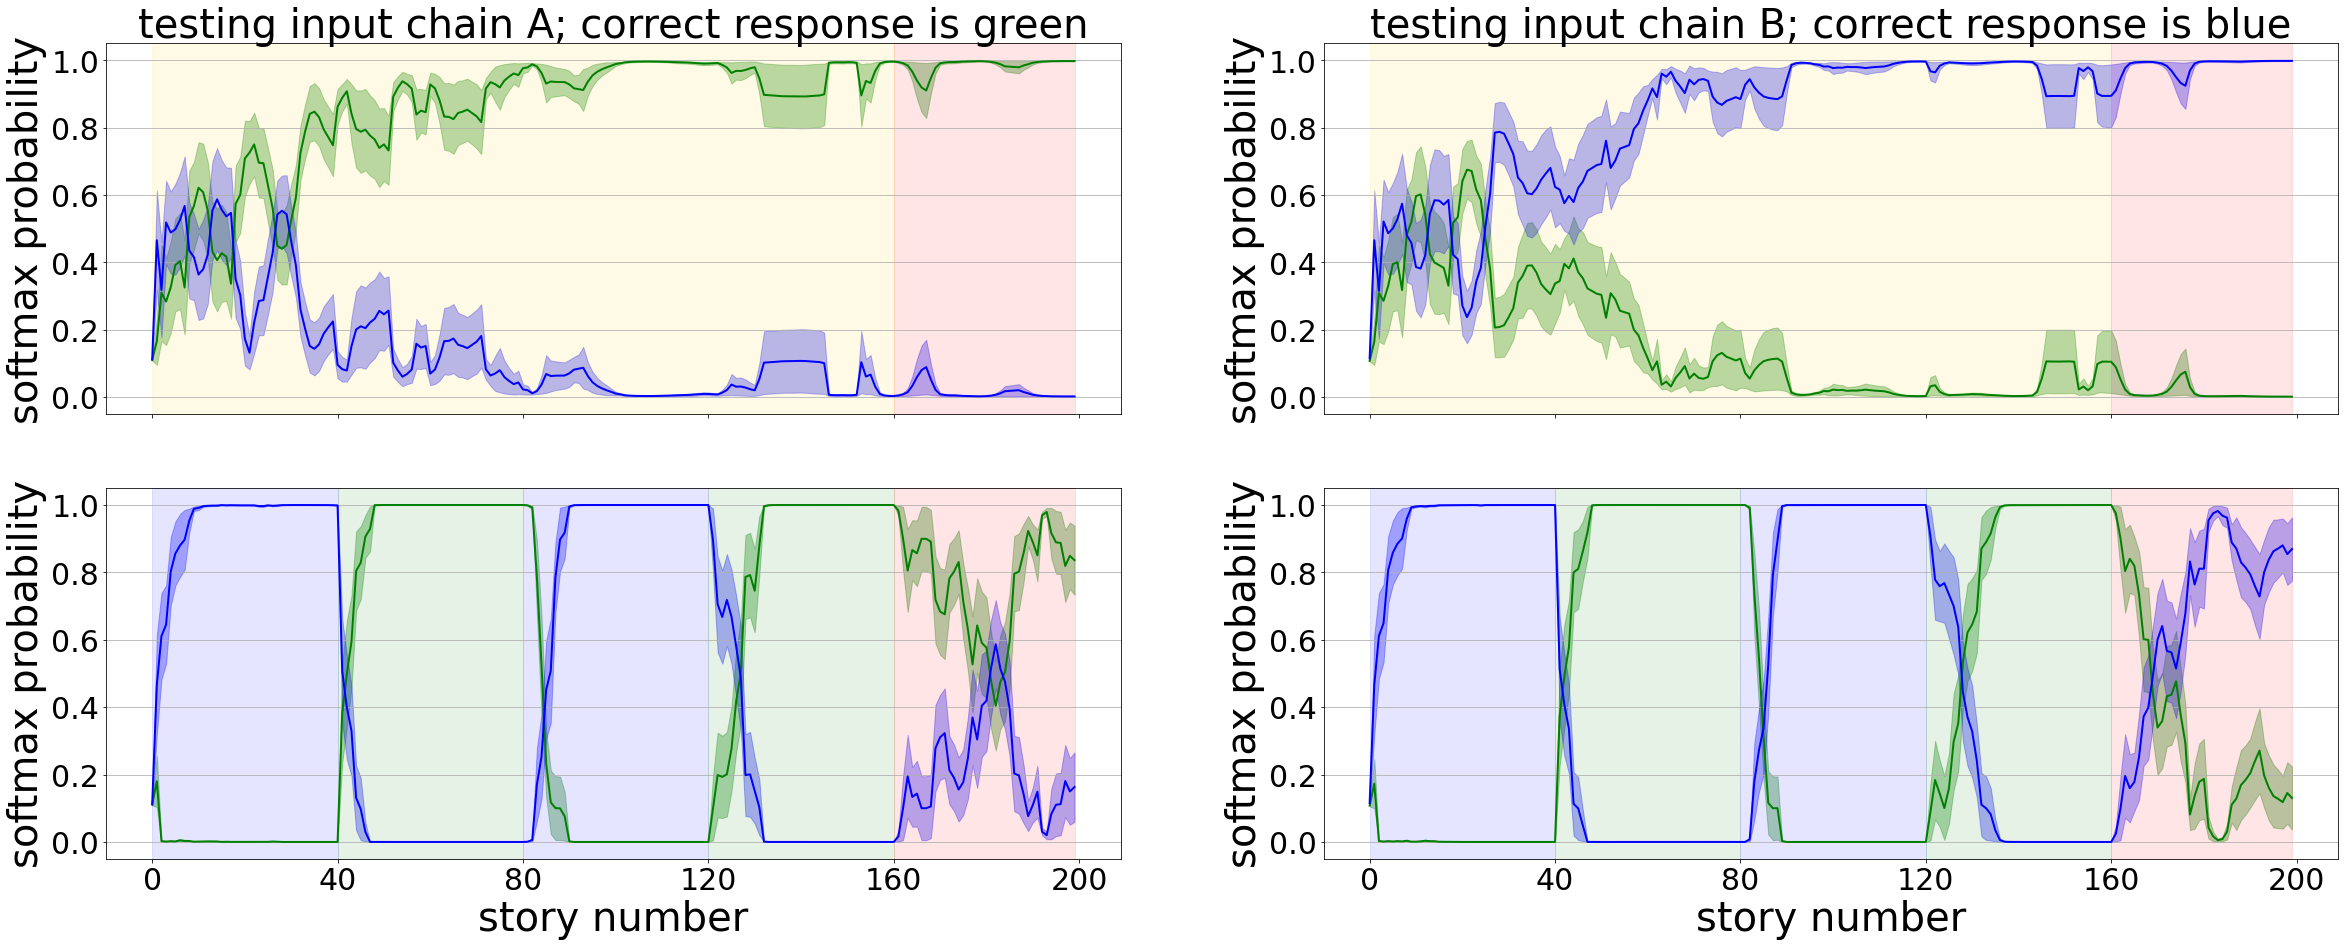

In [190]:
# plot results of softmax analysis
tstep = 1
nodes = (5,6)
cL=['g','b']
labL = ['left','right']
tL = ['testing input chain A; correct response is green','testing input chain B; correct response is blue']
fig,axarr = plt.subplots(2,2,figsize=(40,15),sharex=True)
for cond_idx,blocked_or_interleaved in enumerate(["interleaved", "blocked"]):
  ysm = condition_to_softmax_evaluation[blocked_or_interleaved]
  ysmM = ysm.mean(0)
  ysmS = ysm.std(0)/np.sqrt(len(ysm))
  for graphid in range(2):
    ax = axarr[cond_idx,graphid]
    ysmM_plt = ysmM[graphid,:,tstep,nodes]
    ysmS_plt = ysmS[graphid,:,tstep,nodes]
    
    for idx,(M,S) in enumerate(zip(ysmM_plt,ysmS_plt)):
      ax.plot(M,lw=2,c=cL[idx],label=labL[idx])
      ax.fill_between(range(200),M-S,M+S,color=cL[idx],alpha=.3,)
      ax.set_ylim(-.05,1.05)
    if blocked_or_interleaved == "blocked":
      for b in range(4):
        ax.fill_between(range(b*40,(b*40)+41),-0.05,1.05,color=cL[(1+b)%2],alpha=.1)
    else:
      ax.fill_between(range(0,161),-0.05,1.05,color='gold',alpha=.1)
    ax.fill_between(range(160,200),-0.05,1.05,color='red',alpha=.1)
    ax.grid(axis='y')
    fsize = 40
    ax.set_ylabel('softmax probability', fontsize = fsize)
    ax.set_xticks(range(0,201,40))
    ax.tick_params(axis='x', labelsize=fsize - 10)
    ax.tick_params(axis='y', labelsize=fsize - 10)
    if cond_idx == 0:
      ax.set_title(tL[graphid], fontsize = fsize)
    else:
      ax.set_xlabel('story number', fontsize = fsize)

### Figure 3 a-c

[0.9]
[0.9]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

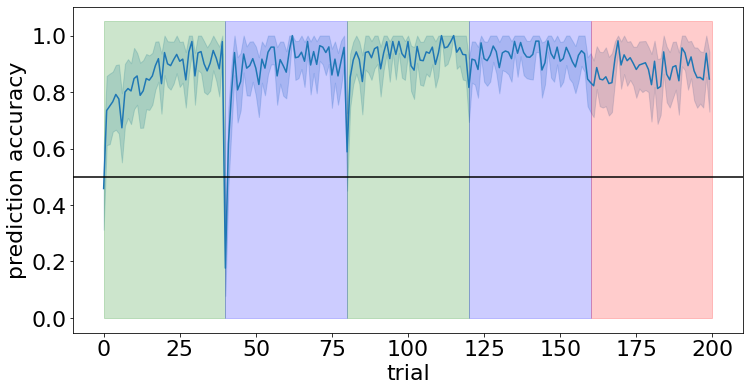

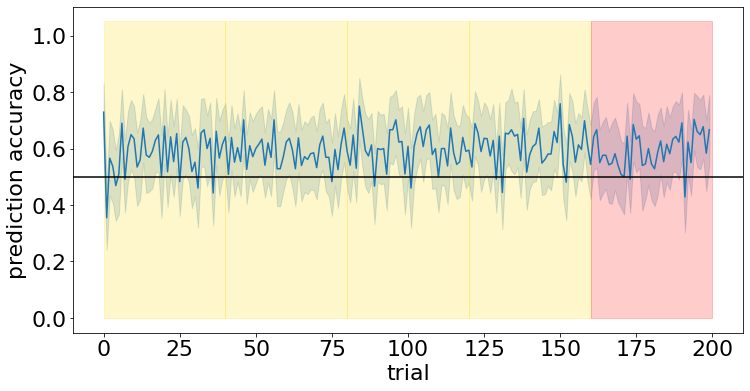

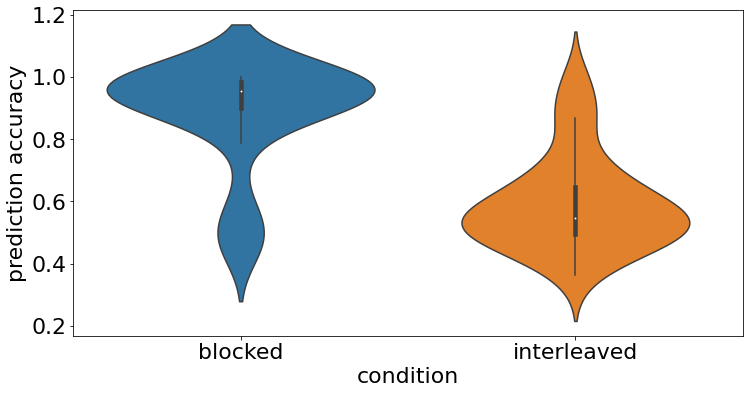

In [151]:
n = 'humanBI'
# sns.set(font = "Verdana")
lineplt(['blocked','interleaved'],0.9,figname=n)
beetestplt(['blocked','interleaved'],0.9,figname=n)

### Figure 3 d-f

[0.9]
[0.9]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

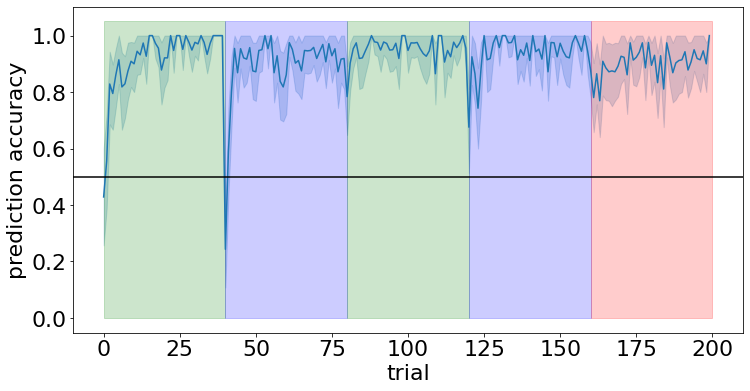

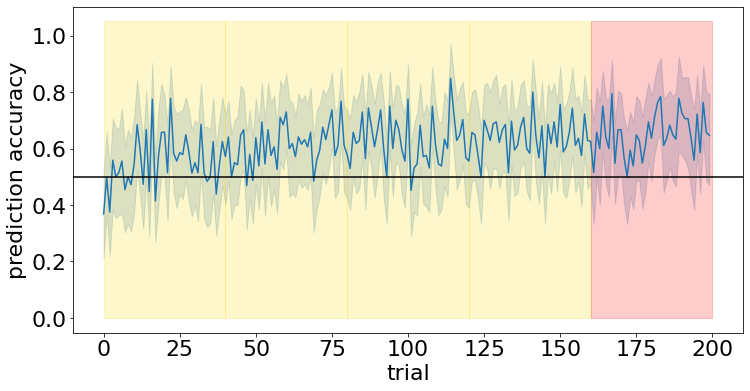

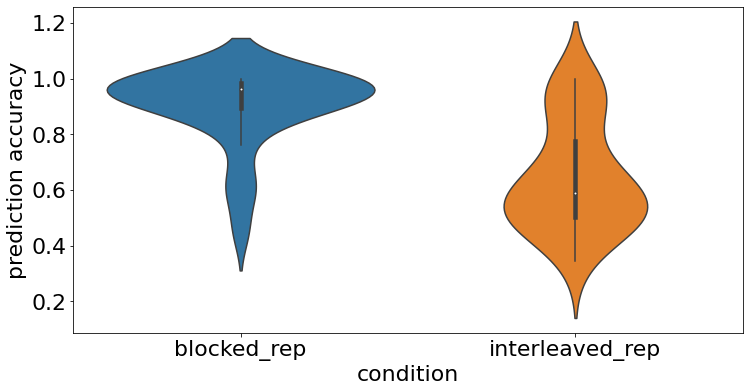

In [152]:
lineplt(['blocked_rep', 'interleaved_rep'],thresh = 0.9)
beetestplt(['blocked_rep','interleaved_rep'],0.9)

### Figure 4

[0.9]


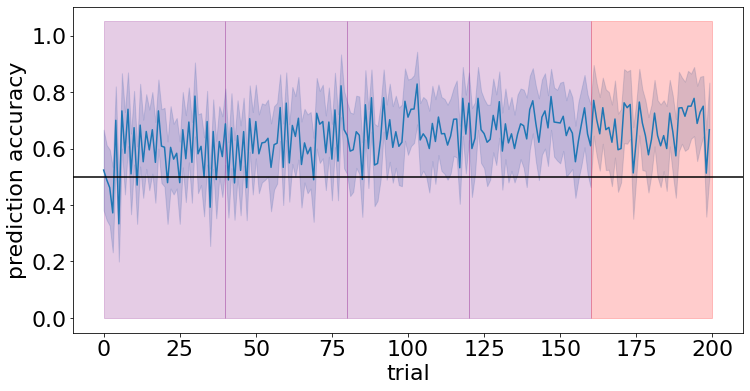

In [153]:
n='explic'
lineplt(['explicit_interleaved'],0.9,figname=n)

# Figure 5

In [154]:
df_amt1 = pd.read_excel('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/amt1_N48.xlsx')
df_amt2 = pd.read_excel('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/amt2_N127.xlsx')
df_amt2["correct"] = [x / 100 for x in df_amt2.correct.tolist()]
df_onsite = pd.read_excel('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/onsite_N30.xlsx')
df_onsite["correct"] = [x / 100 for x in df_onsite.correct.tolist()]

[Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.6, '0.6'),
 Text(0, 0.8, '0.8'),
 Text(0, 1.0, '1.0')]

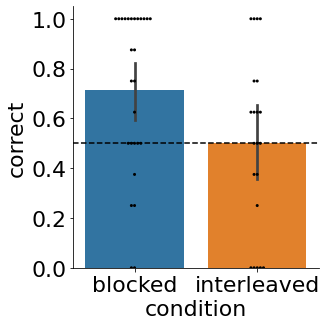

In [155]:

g = sns.catplot(data=df_amt1, x="condition", y="correct", kind="bar")
sns.swarmplot(data=df_amt1, x="condition", y="correct", color="k", size=3, ax=g.ax)
#g.ax.set(title='AMT participants (N=48)', ylabel='correct (%)', xlabel = "")
g.ax.axhline((1/2), ls='--', color = "black")
g.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
g.ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])


[Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.6, '0.6'),
 Text(0, 0.8, '0.8'),
 Text(0, 1.0, '1.0')]

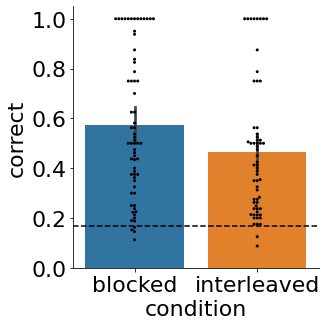

In [156]:

g = sns.catplot(data=df_amt2, x="condition", y="correct", kind="bar")
sns.swarmplot(data=df_amt2, x="condition", y="correct", color="k", size=3, ax=g.ax)
#g.ax.set(title='AMT participants (N=127)', ylabel='correct (%)', xlabel = "")
g.ax.axhline((1/6), ls='--', color = "black")
g.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
g.ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])



[Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.6, '0.6'),
 Text(0, 0.8, '0.8'),
 Text(0, 1.0, '1.0')]

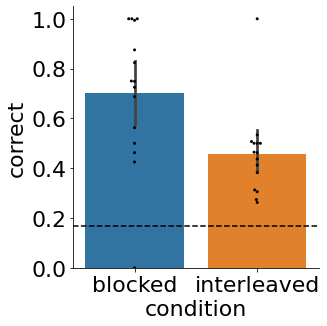

In [157]:

g = sns.catplot(data=df_onsite, x="condition", y="correct", kind="bar")
g.ax.set(xlabel='Undergraduate participants (N=30)', ylabel='correct (%)')
sns.swarmplot(data=df_onsite, x="condition", y="correct", color="k", size=3, ax=g.ax)
#g.ax.set(title='Undergraduate participants (N=30)', ylabel='correct (%)', xlabel = "")
g.ax.axhline((1/6), ls='--', color = "black")
g.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
g.ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])


# Figure 6 a & b


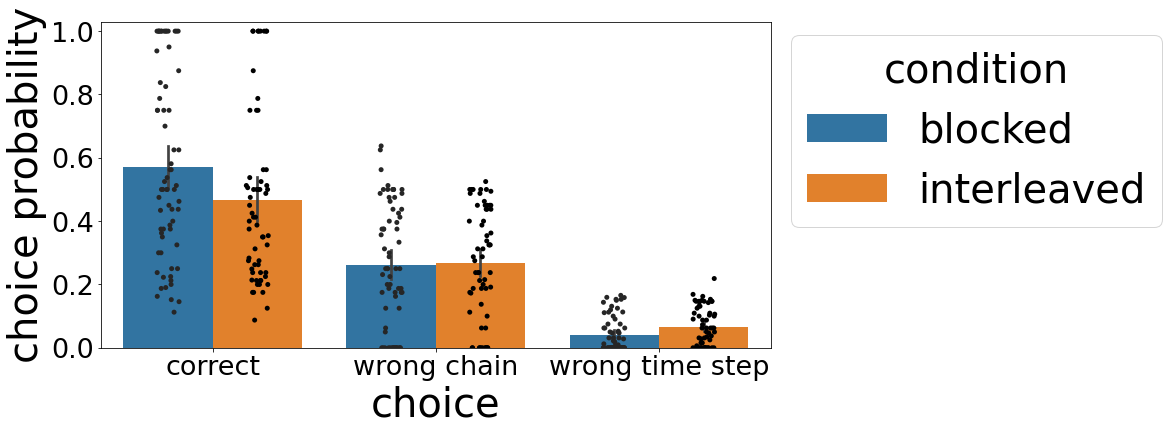

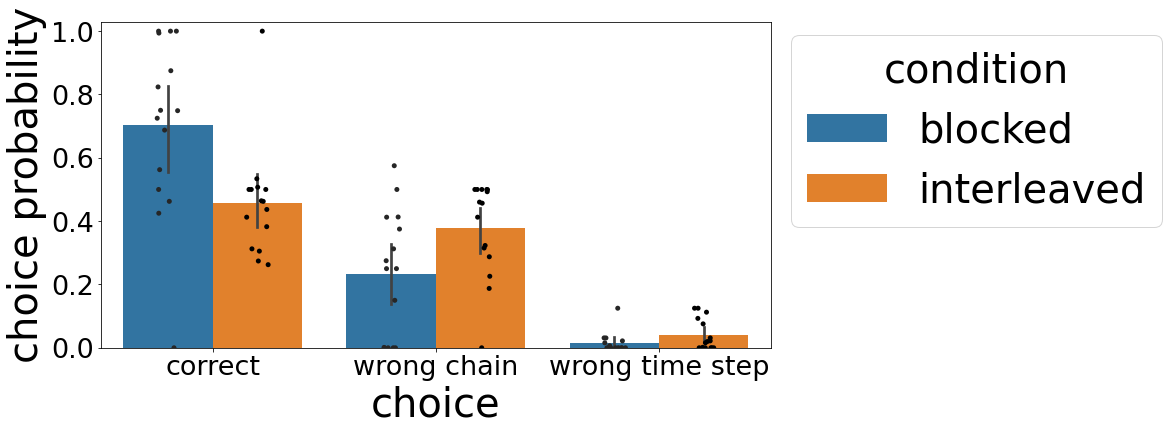

In [211]:
def plt_data(df):

  plt.figure(figsize=(12,6))
  ax = plt.gca()
  df.loc[:,"wrong time step"] = df.loc[:,"wrong time step"]/4
  df = df.melt(id_vars='curriculum',value_vars=['correct',"wrong schema", "wrong time step"])
  df['variable'] = df['variable'].str.replace("wrong schema","wrong chain")
  df = df.rename(columns = {"curriculum":"condition"})
  df.value = df.value/100
  ax = sns.barplot(
    data=df,
    x='variable',y='value',hue='condition',ax=ax,hue_order=['blocked','interleaved'],ci=95
  )
  sns.stripplot(
    data=df,
    x='variable',y='value',hue='condition',ax=ax,hue_order=['blocked','interleaved'], dodge = True, size = 5, color = "k"
)
  fsize = 40
  ax.set_ylabel('choice probability', fontsize = fsize)
  ax.set_xlabel('choice', fontsize = fsize)
  ax.set_ylim(0,1.03)
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles[2:], labels[2:], title='condition', bbox_to_anchor=(1, 1.02), loc='upper left', fontsize = fsize)
  plt.setp(ax.get_legend().get_title(), fontsize='40')  
  ax.tick_params(axis='both', which='major', labelsize=fsize - 13)
  #ax.tick_params(axis='both', which='minor', labelsize=8)
  from matplotlib import ticker as mtick
  #ax.tick_params(axis='x', labelsize=fsize - 10)
  #ax.tick_params(axis='y', labelsize=fsize - 10)
  # fmt = '%.1f'  # as per no of zero(or other) you want after decimal point
  # yticks = mtick.FormatStrFormatter(fmt)
  # plt.gca().yaxis.set_major_formatter(yticks)

# PROCESSING 2
A,B = "wrong schema", "wrong time step"
df2 = pd.read_excel('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/AV_data_onlineExpt.xlsx')
df2.columns = ['curriculum',df2.columns[1],A,B]

# ONLINE PLOT
plt_data(df2)

## PROCESSSING
df1 = pd.read_excel('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/AV_data_onSiteExpt.xlsx')
df1.columns = [*df1.columns[:2],A,B,'curriculum']

## ONSITE PLOT
l = plt_data(df1)

# modeling

## load model dfs

In [159]:
model_acc_df = pd.read_csv(f"https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sims_acc_df.csv")

model_states_df_1to2 = pd.read_csv("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sims_states_df_1to2.csv")
model_states_df_3 = pd.read_csv("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sims_states_df_3.csv")
model_states_df_4to6 = pd.read_csv("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sims_states_df_4to6.csv")
model_states_df_7 = pd.read_csv("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sims_states_df_7.csv")

model_acc_df = model_acc_df.astype({'cond_int': 'int32'})
model_acc_df = model_acc_df.astype({'cond': 'string'})
model_acc_df = model_acc_df.astype({'gs': 'string'})

model_states_df_1to2 = model_states_df_1to2.astype({'gs': 'string'})
model_states_df_3 = model_states_df_3.astype({'gs': 'string'})
model_states_df_4to6 = model_states_df_4to6.astype({'gs': 'string'})
model_states_df_7 = model_states_df_7.astype({'gs': 'string'})

model_states_df_1to2.loc[:,'cond_int'] = model_states_df_1to2.cond
model_states_df_3.loc[:,'cond_int'] = model_states_df_3.cond
model_states_df_4to6.loc[:,'cond_int'] = model_states_df_4to6.cond
model_states_df_7.loc[:,'cond_int'] = model_states_df_7.cond

model_states_df_1to2.cond = model_states_df_1to2.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])
model_states_df_3.cond = model_states_df_3.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])
model_states_df_4to6.cond = model_states_df_4to6.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])
model_states_df_7.cond = model_states_df_7.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])

model_states_df_1to2 = model_states_df_1to2.astype({'cond_int': 'int32'})
model_states_df_3 = model_states_df_3.astype({'cond_int': 'int32'})
model_states_df_4to6 = model_states_df_4to6.astype({'cond_int': 'int32'})
model_states_df_7 = model_states_df_7.astype({'cond_int': 'int32'})

model_states_df_1to2 = model_states_df_1to2.astype({'cond': 'string'})
model_states_df_3 = model_states_df_3.astype({'cond': 'string'})
model_states_df_4to6 = model_states_df_4to6.astype({'cond': 'string'})
model_states_df_7 = model_states_df_7.astype({'cond': 'string'})

r = requests.get('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sim_to_args.json')
sim_to_args = r.json()

## plotting functions

In [222]:

def lineplot_model(gsname,condstr,ax=None):

  if not ax:
    plt.figure(figsize=(12,8))
    ax = plt.gca()
  ax.axhline(0.5,c='k')
  sns.lineplot(
    data=model_acc_df.query(f"gs=='{gsname}'&{condstr}"
                  ).groupby(['trial','cond']).mean().reset_index(),
    x='trial',y='acc',hue='cond',ax=ax, linewidth = 2
  )
  ax.set_xticks([0,25,50,75,100,125,150,175,200]) 
  ax.set_yticks([0.0, 0.2,0.4,0.6,0.8,1.0])

  fsize = 45
  ax.set_xticklabels([str(x) for x in [0,25,50,75,100,125,150,175,200]], fontsize = fsize - 10)
  ax.set_yticklabels([y for y in ["0.0", "0.2","0.4","0.6","0.8","1.0"]], fontsize = fsize - 10)
  ax.set_ylabel('prediction accuracy', fontsize = fsize)
  ax.set_xlabel('trial', fontsize = fsize)

  # ax.set_xticklabels([str(x) for x in [0,25,50,75,100,125,150,175,200]])
  # ax.set_yticklabels([y for y in ["0.0", "0.2","0.4","0.6","0.8","1.0"]])
  # ax.set_ylabel('prediction accuracy')
  # ax.set_xlabel('trial')
  ax.legend().remove()
  if TITLES_ON:
    ax.set_title(gsname+" COND-"+condstr)
  return ax
  
def lineplot_modelBI(gsname,ax=None):
  for ix in [0,1]:
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}',ax=None)
    color_background(ax,['blocked','interleaved'][ix])

def lineplot_modelEML(gsname):
  for ix in [2,3,4]:
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}',ax=None)
    color_background(ax,['early','middle','late'][ix-2])

def beeswarm_model(gsname,condstr,ax=None):
  
  if not ax:
    plt.figure(figsize=(12,8))
    ax = plt.gca()
  sns.violinplot(
    data=model_acc_df.query(f"gs=='{gsname}'&test==True&{condstr}"
                  ).groupby(['seed','cond'], sort=False).mean().reset_index(),
    x='cond',y='acc',ax=ax
  )
  fsize = 45
  ax.set_ylabel('prediction accuracy', fontsize = fsize) 
  ax.set_xlabel('condition', fontsize = fsize)
  ax.tick_params(axis='x', labelsize=fsize - 10)
  ax.tick_params(axis='y', labelsize=fsize - 10)
  # ax.set_ylabel('prediction accuracy') 
  # ax.set_xlabel('condition')
  # ax.tick_params(axis='x')
  # ax.tick_params(axis='y')
  if TITLES_ON:
    ax.set_title(gsname+" COND-"+condstr)

def beeswarm_modelBI(gsname):
  beeswarm_model(gsname,condstr='cond_int<2')

def beeswarm_modelEML(gsname):
  beeswarm_model(gsname,condstr='cond_int>=2')


# Figure 7

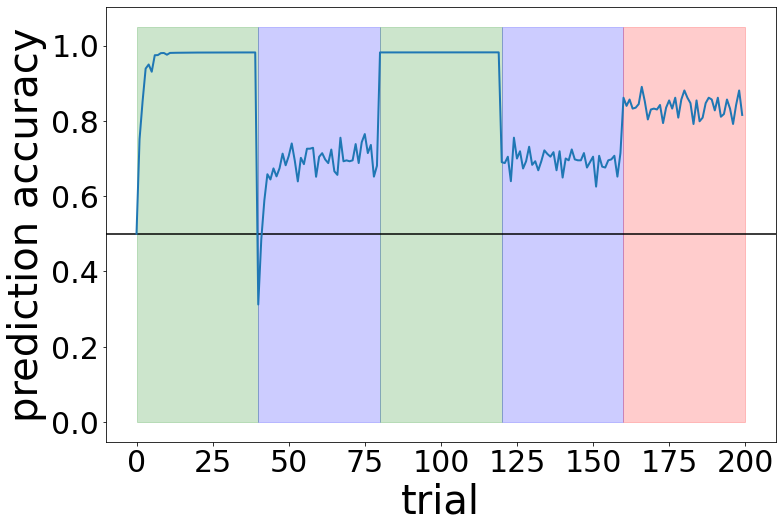

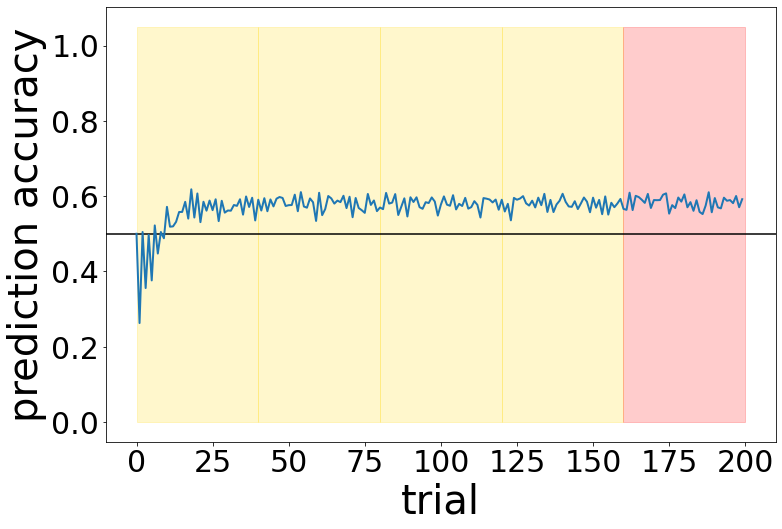

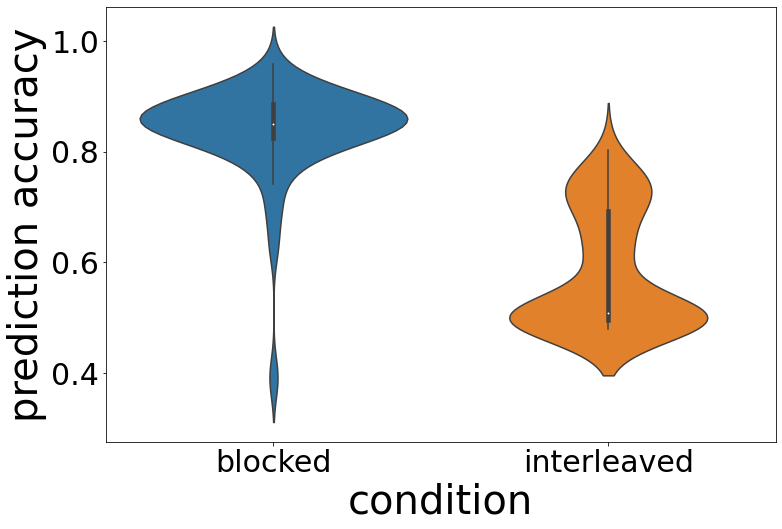

In [213]:
gsname = "sim1"
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

# Figure 8 a-c

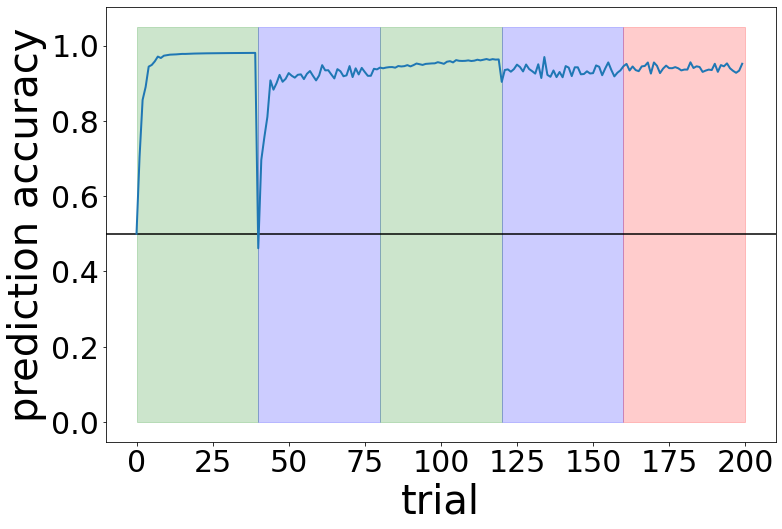

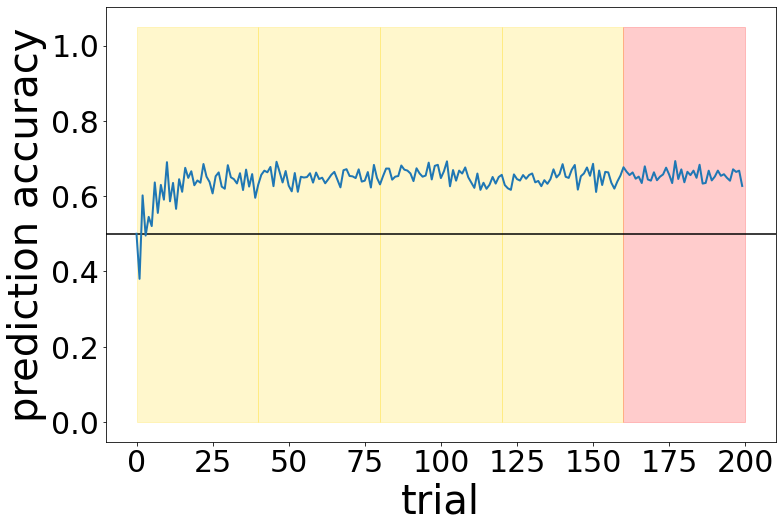

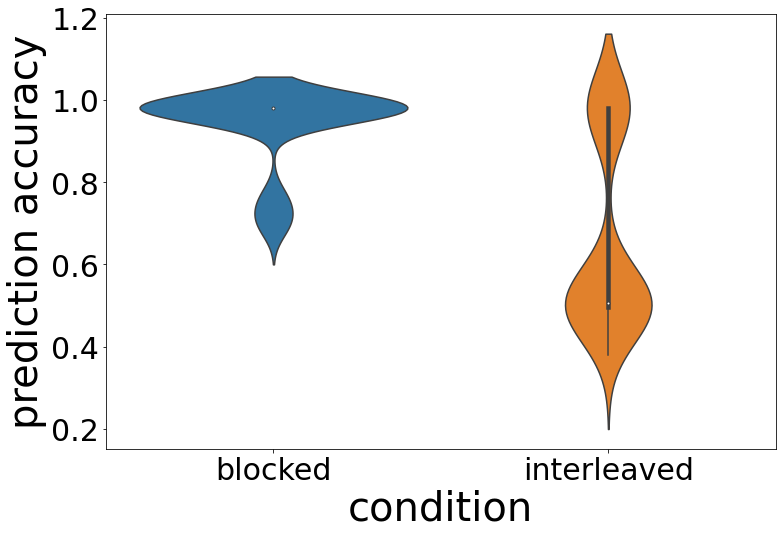

In [214]:
gsname = 'sim2'
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

# Figure 8 d

 no rep pid_acc_list:  39
rep pid_acc_list:  63


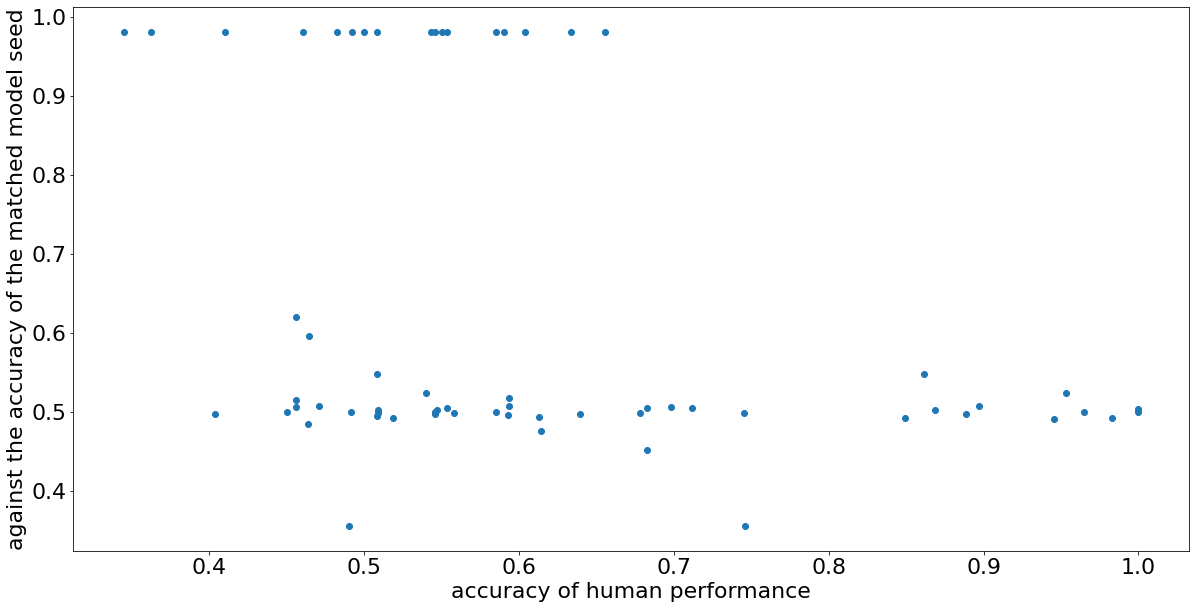

In [215]:
# get the scatter plots 
gsname = 'sim2'
args = sim_to_args[gsname]
# INTERLEAVED
participant_to_exp_path = 'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/versionX_interleaved_participant_to_exp.pickle'
participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials
each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
participant_to_testAcc_path = 'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/versionX_interleaved_participant_to_testAcc.pickle'
participant_to_testAcc = pickle.load(BytesIO(requests.get(participant_to_testAcc_path).content))
pid_acc_list = []
matched_seed_acc_list = []
for pid in sorted(list(participant_to_testAcc.keys())):
  matched_seed_acc_list.append(each_matched_seed_acc[pid])
  pid_acc_list.append(participant_to_testAcc[pid])
print(" no rep pid_acc_list: ", len(pid_acc_list))

# interleaved rep
participant_to_exp_path = 'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/versionX_interleavedRep_participant_to_exp.pickle'
participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials
each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
participant_to_testAcc_path = 'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/versionX_interleavedRep_participant_to_testAcc.pickle'
participant_to_testAcc = pickle.load(BytesIO(requests.get(participant_to_testAcc_path).content))
for pid in sorted(list(participant_to_testAcc.keys())):
  matched_seed_acc_list.append(each_matched_seed_acc[pid])
  pid_acc_list.append(participant_to_testAcc[pid])
print("rep pid_acc_list: ", len(pid_acc_list))
plt.figure(figsize=(20,10))
plt.scatter(pid_acc_list,matched_seed_acc_list)
plt.xlabel("accuracy of human performance")
plt.ylabel("against the accuracy of the matched model seed")
r, pval = scipy.stats.pearsonr(pid_acc_list,matched_seed_acc_list)



# Figure 9


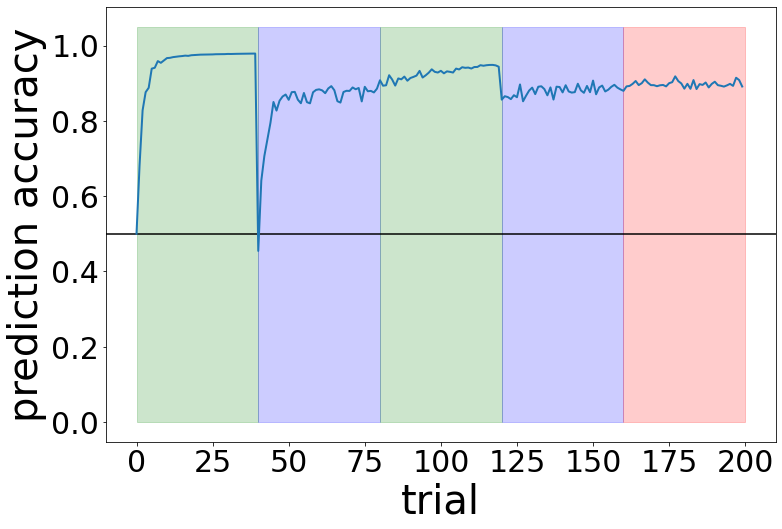

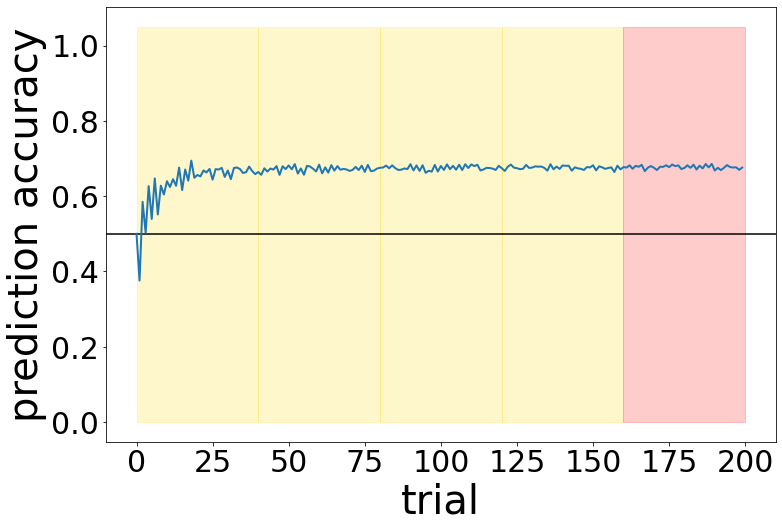

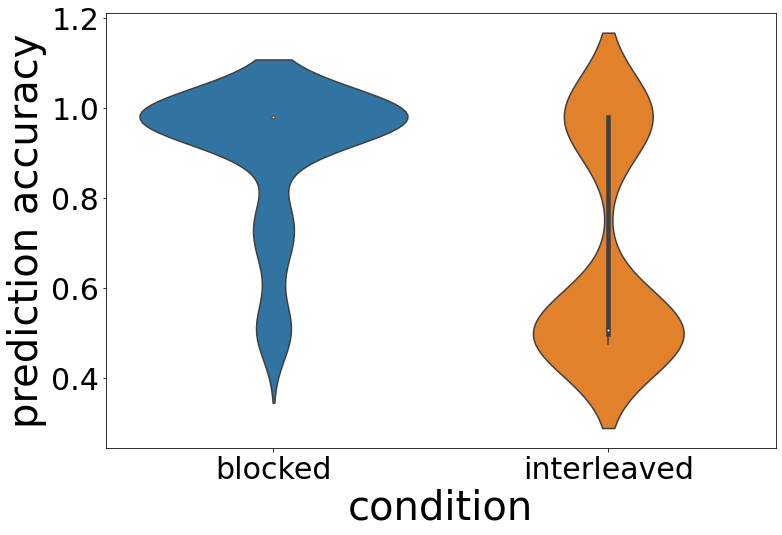

In [216]:
gsname="sim3"
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

In [217]:
def scatter_numlc_vs_acc(gsname,ax=None):
  if not ax:
    plt.figure(figsize=(12,8))
    ax=plt.gca()
  cond = 1
  if int(gsname[-1]) == 1 or int(gsname[-1]) == 2:
    this_model_states_df = model_states_df_1to2
  elif int(gsname[-1]) == 3:
    this_model_states_df = model_states_df_3
  elif int(gsname[-1]) == 7:
    this_model_states_df = model_states_df_7
  else:
    this_model_states_df = model_states_df_4to6
  for six in range(100):
    q = f"gs=='{gsname}'&cond_int=={cond}&trial>=160&seed=={six}"

    seed_states_df = this_model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean() 
    nlc = seed_states_df.zt.max()+1
    ax.scatter(nlc,sacc,c='k')
  fsize = 40
  ax.set_ylabel('test accuracy', fontsize = fsize)
  ax.set_xlabel('number of latent causes', fontsize = fsize)
  ax.tick_params(axis='x', labelsize=fsize - 10)
  ax.tick_params(axis='y', labelsize=fsize - 10)
  if TITLES_ON:
    ax.set_title(gsname)

def scatter_varied_parameter_vs_numlc(gsname,varied_parameter_name, ax=None):
  if not ax:
    plt.figure(figsize=(12,8))
    ax=plt.gca()
  q = f"gs=='{gsname}'&cond_int==1"
  if int(gsname[-1]) == 1 or int(gsname[-1]) == 2:
    this_model_states_df = model_states_df_1to2
  elif int(gsname[-1]) == 3:
    this_model_states_df = model_states_df_3
  elif int(gsname[-1]) == 7:
    this_model_states_df = model_states_df_7
  else:
    this_model_states_df = model_states_df_4to6

  print(this_model_states_df.dtypes)
  for six,sdf in this_model_states_df.query(q).groupby('seed'):
    numlc=sdf.zt.max()
    ax.scatter(sdf.varied_parameter.unique(),numlc+1,c='k')
  fsize = 40
  ax.set_xlabel(varied_parameter_name, fontsize = fsize)
  ax.set_ylabel('number of latent causes', fontsize = fsize)
  ax.tick_params(axis='x', labelsize=fsize - 10)
  ax.tick_params(axis='y', labelsize=fsize - 10)
  if TITLES_ON:
    ax.set_title(gsname)

def scatter_varied_parameter_vs_acc(gsname,varied_parameter_name, ax=None):
  if not ax:
    plt.figure(figsize=(12,8))
    ax=plt.gca()
  cond=1
  if int(gsname[-1]) == 1 or int(gsname[-1]) == 2:
    this_model_states_df = model_states_df_1to2
  elif int(gsname[-1]) == 3:
    this_model_states_df = model_states_df_3
  elif int(gsname[-1]) == 7:
    this_model_states_df = model_states_df_7
  else:
    this_model_states_df = model_states_df_4to6
  print(this_model_states_df.dtypes)
  for six in range(100):
    q = f"gs=='{gsname}'&cond_int=={cond}&trial>=160&seed=={six}"
    seed_states_df = this_model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean() 
    varied_parameter = this_model_states_df.query(q).varied_parameter.unique()[0]
    ax.scatter(varied_parameter,sacc,c='k')
  fsize = 40
  ax.set_xlabel(varied_parameter_name, fontsize = fsize)
  ax.set_ylabel('test accuracy', fontsize = fsize)
  ax.tick_params(axis='x', labelsize=fsize - 10)
  ax.tick_params(axis='y', labelsize=fsize - 10)
  if TITLES_ON:
    ax.set_title(gsname)
  return None

Unnamed: 0            int64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object
Unnamed: 0            int64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object


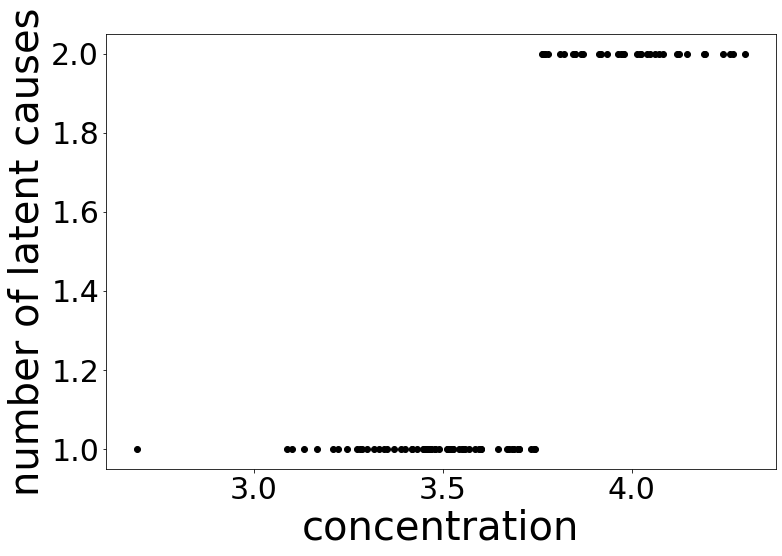

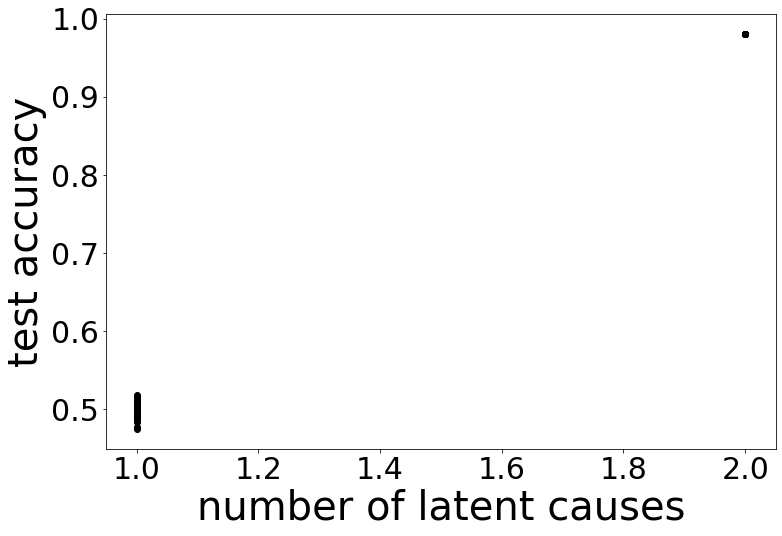

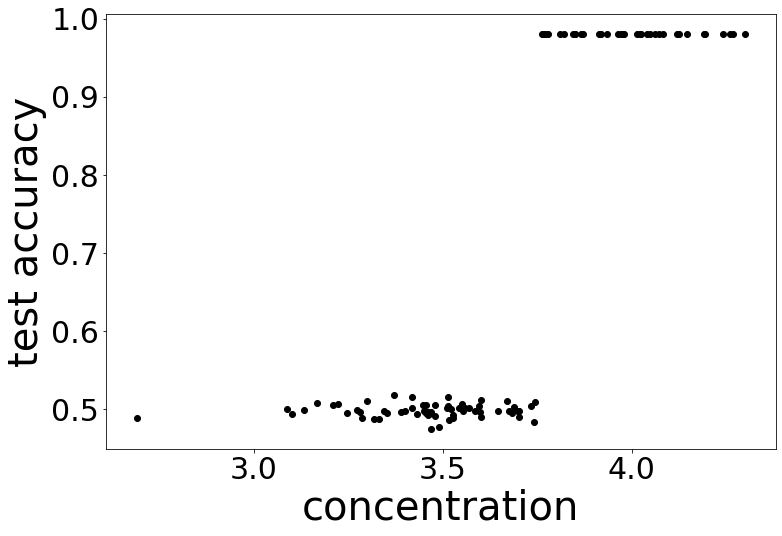

In [218]:


scatter_varied_parameter_vs_numlc("sim3", varied_parameter_name= "concentration")
scatter_numlc_vs_acc("sim3")
scatter_varied_parameter_vs_acc("sim3", varied_parameter_name= "concentration")

# Figure 10 a-d

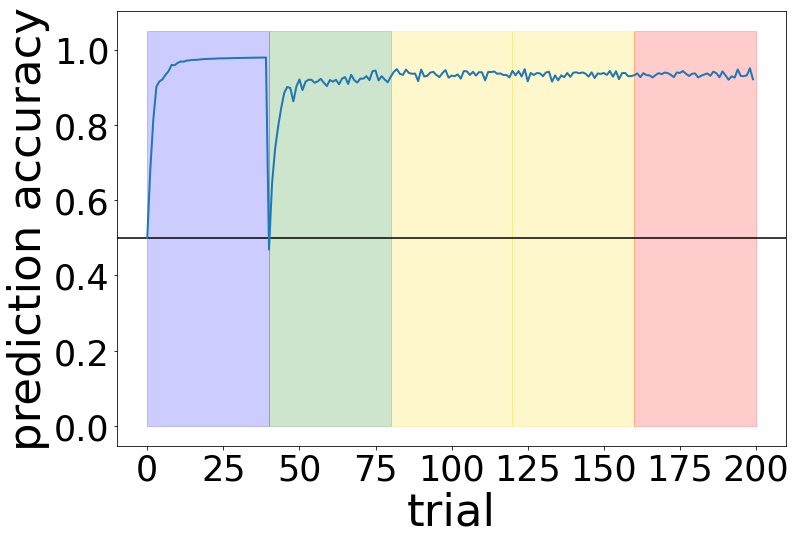

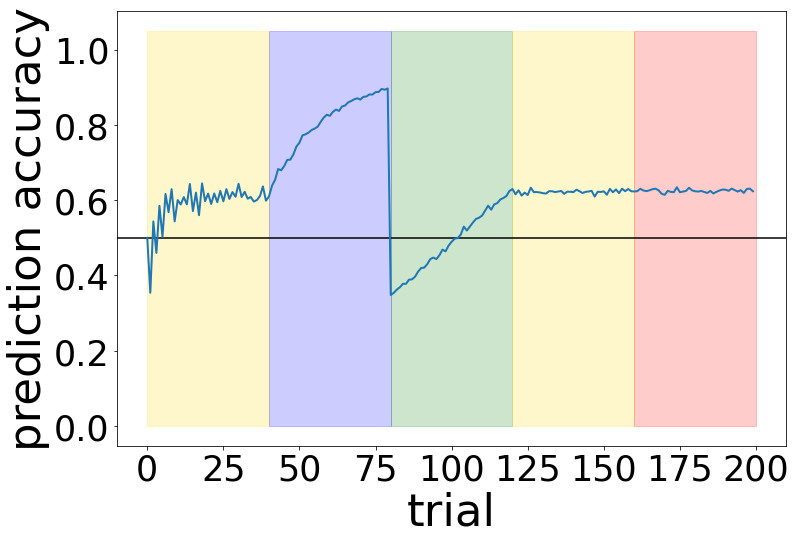

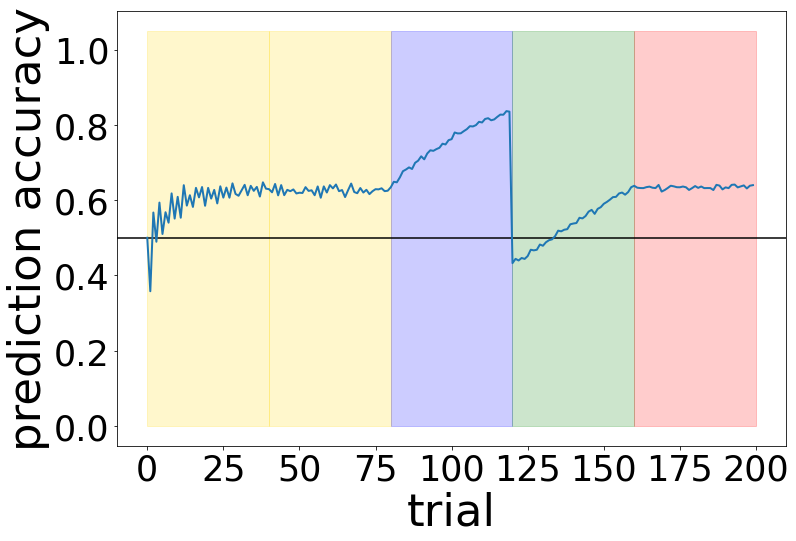

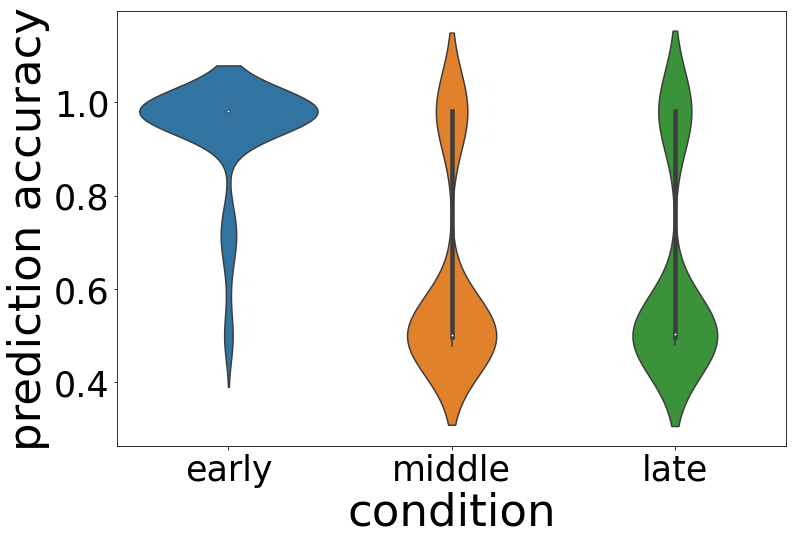

In [231]:
gsname="sim3"
lineplot_modelEML(gsname)
beeswarm_modelEML(gsname)

# Figure 10 e-h

In [232]:
condL = ['inserted_early','inserted_middle','inserted_late']

lineplt(condL,0.9)
beetestplt(condL,0.9)

[0.9]


# Figure 10 i-l

[0.9]
[0.9]
[0.9]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

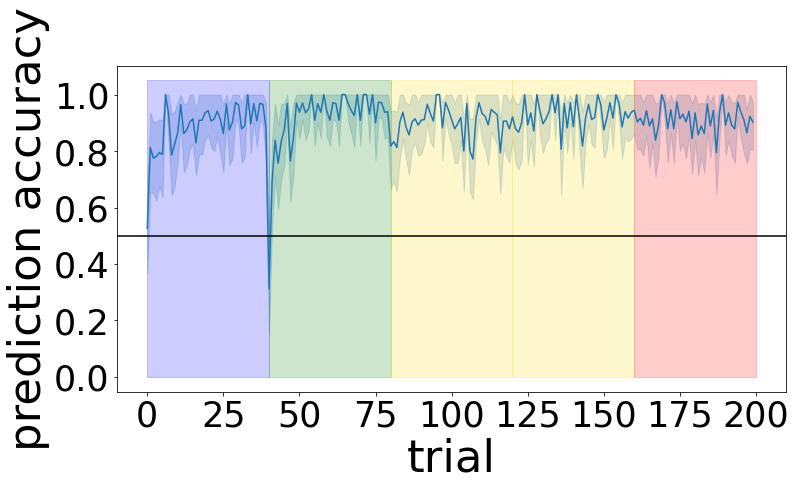

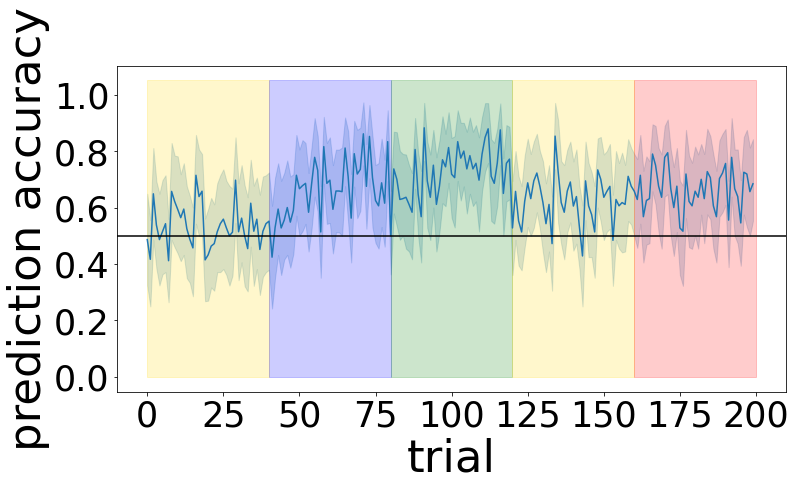

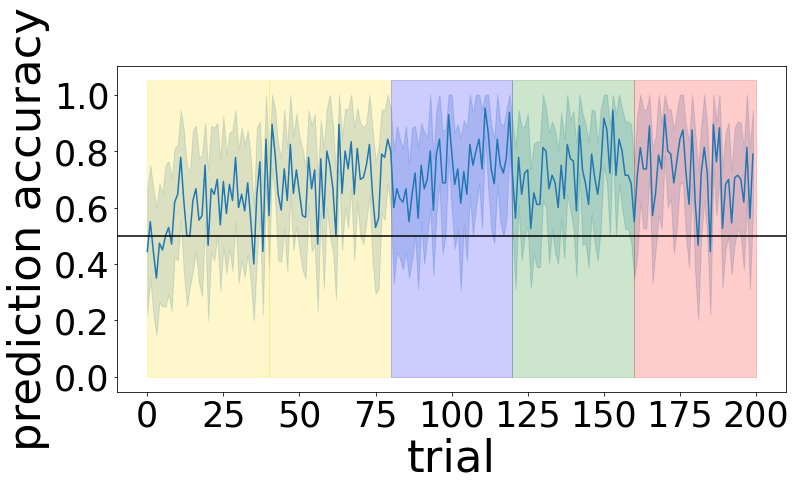

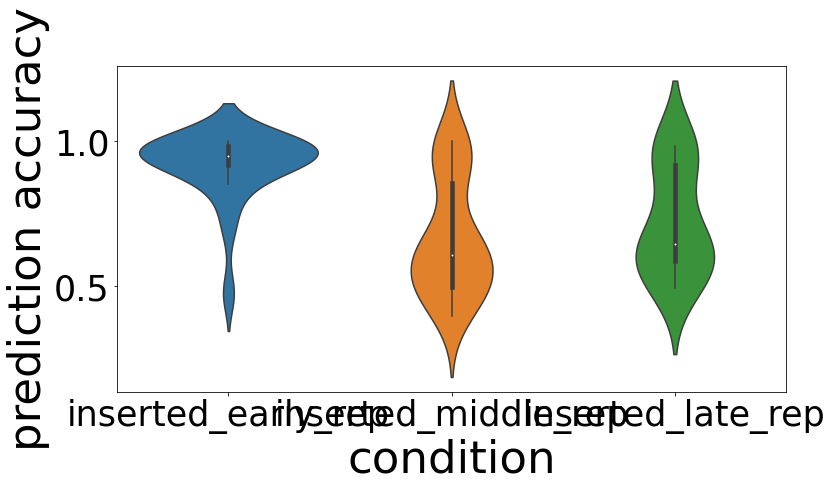

In [ ]:
condL = ['inserted_early_rep','inserted_middle_rep','inserted_late_rep']

lineplt(condL,0.9)
beetestplt(condL,0.9)

# Figure S1 a, b, d & e

[0.9]
[0.9]
[0.9]
[0.9]


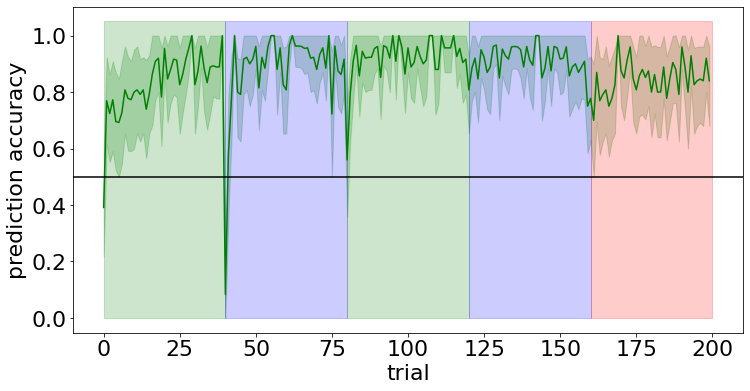

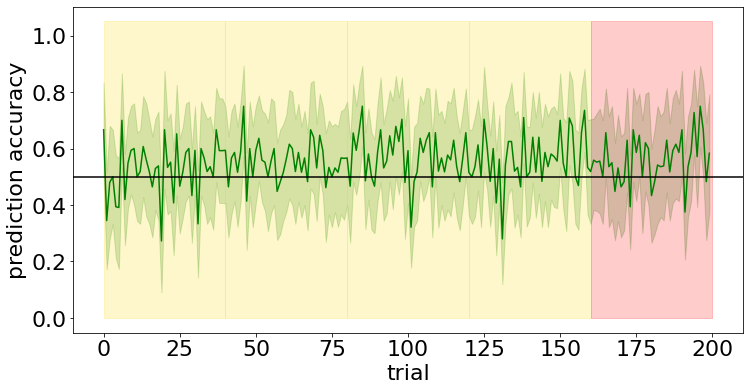

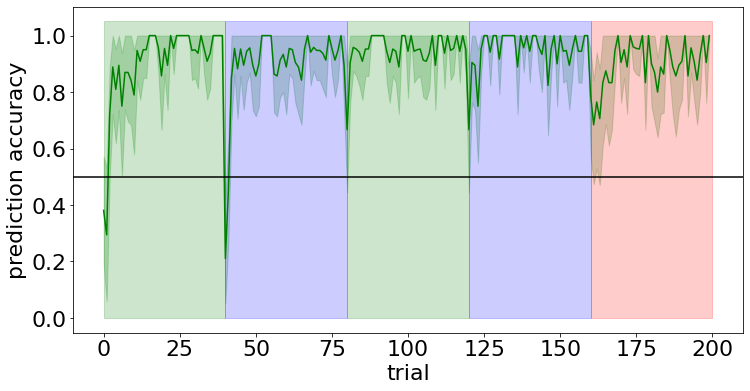

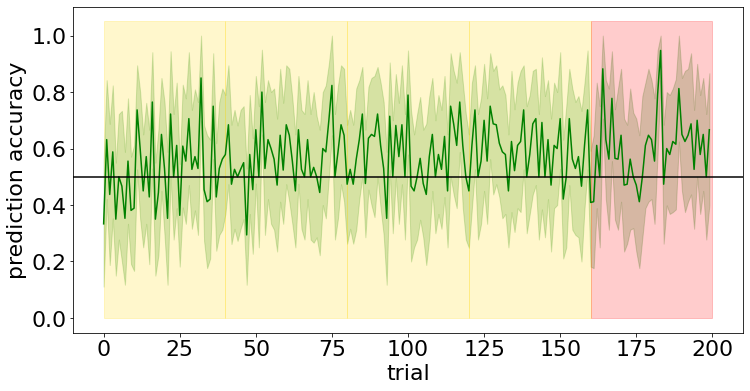

In [170]:
n='trans2'
cL = ["blocked","interleaved","blocked_rep","interleaved_rep"]
lineplt(cL,0.9,transition=1,fgkw={'color':'g'},figname=n)


# Figure S1 c & f

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

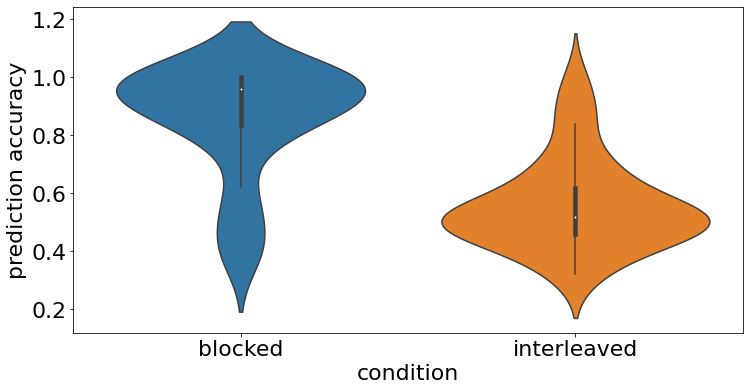

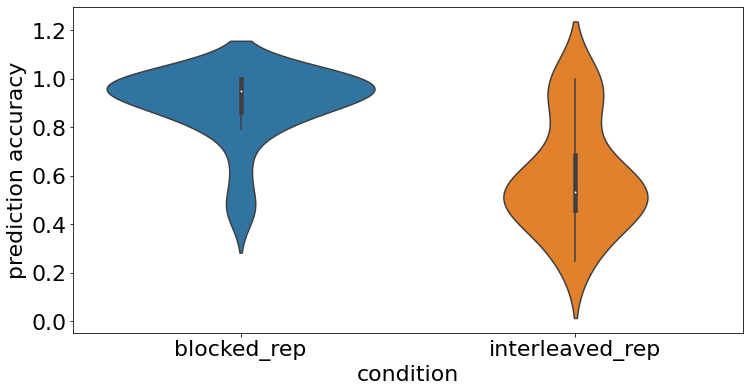

In [171]:
n='trans2'
beetestplt(['blocked','interleaved'],0.9,transition=1,figname=n)
beetestplt(['blocked_rep','interleaved_rep'],0.9,transition=1,figname=n)

# Figure S2 a, b, d, e

[0.9]
[0.9]
[0.9]
[0.9]


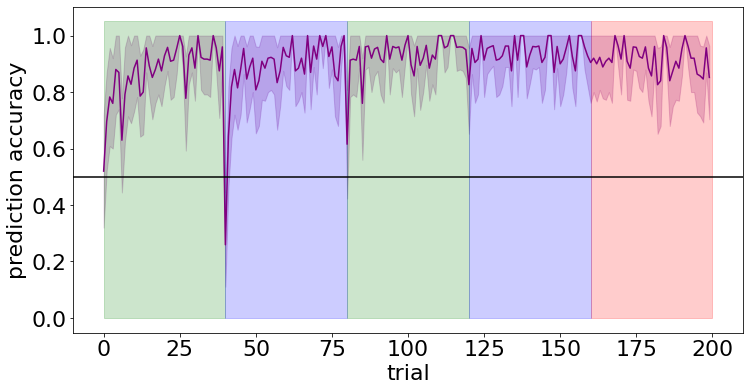

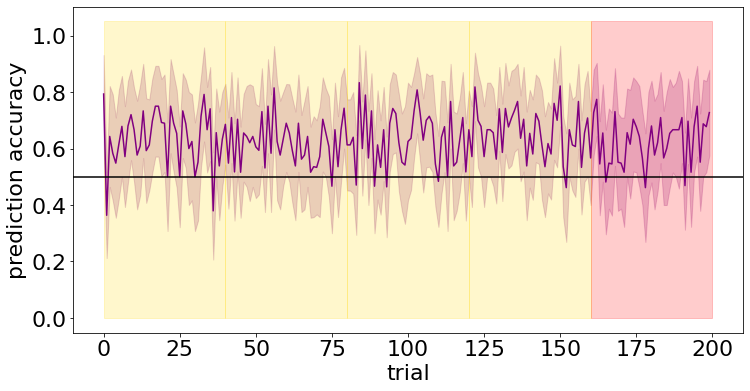

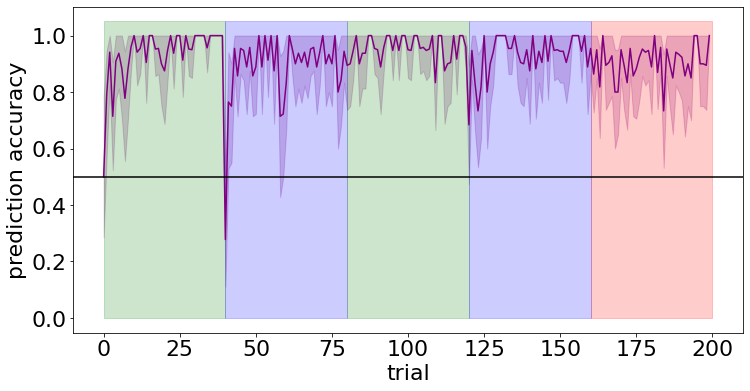

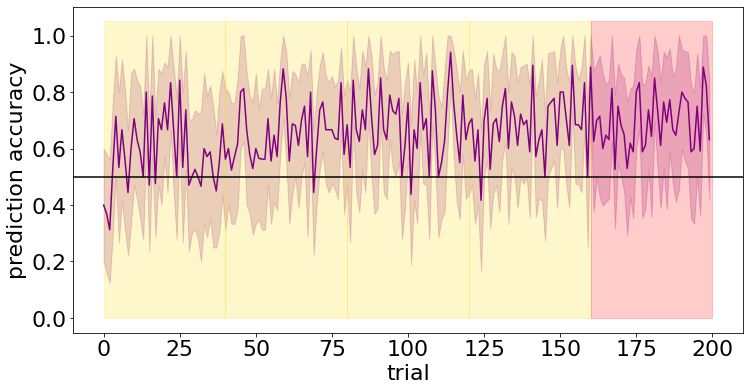

In [172]:
n='trans3'
lineplt(cL,0.9,transition=2,fgkw={'color':'purple'},figname=n)

# Figure S2 c & f

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

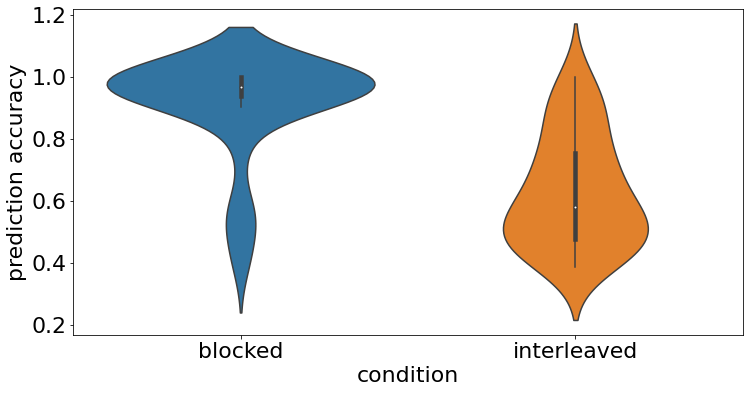

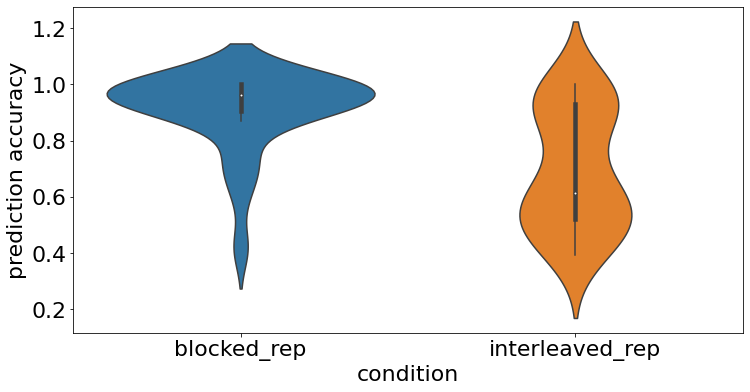

In [173]:
n='trans3'
beetestplt(['blocked','interleaved'],0.9,transition=2,figname=n)
beetestplt(['blocked_rep','interleaved_rep'],0.9,transition=2,figname=n)


# Figure S3 a-c

[0.]
[0.]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

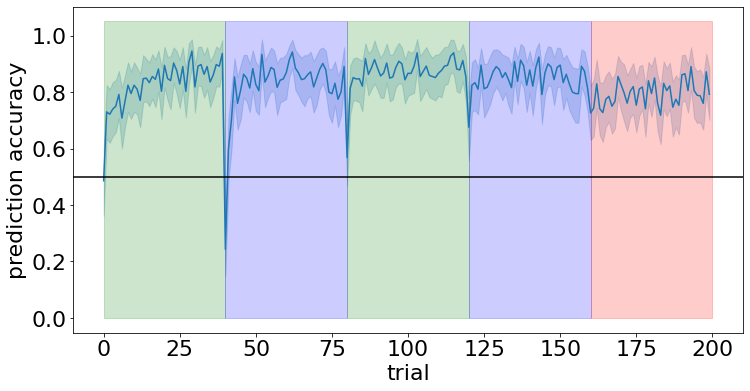

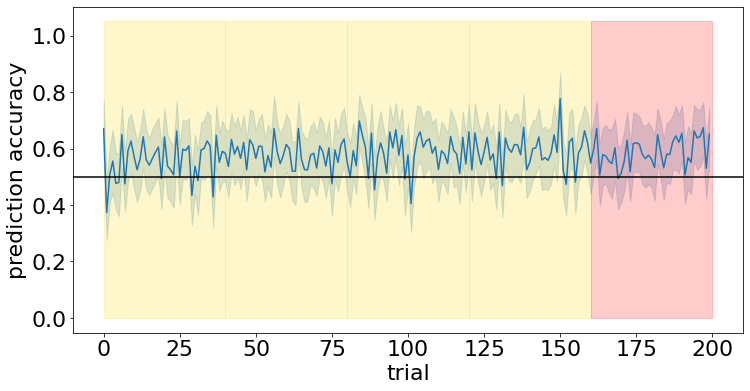

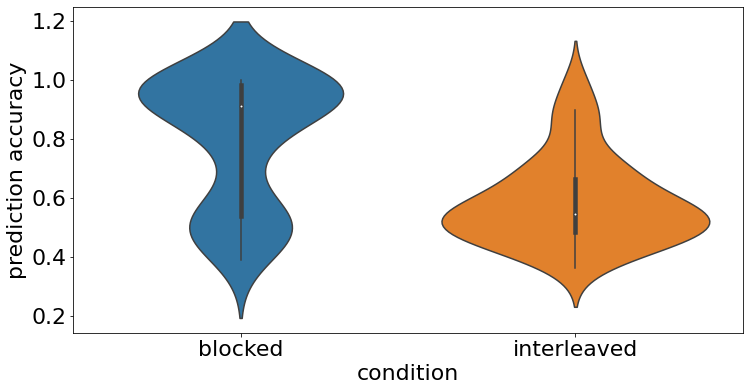

In [174]:
n = 'humanBI'
lineplt(['blocked','interleaved'],0,figname=n)
beetestplt(['blocked','interleaved'],0,figname=n)

# Figure S3 d-f

[0.]
[0.]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

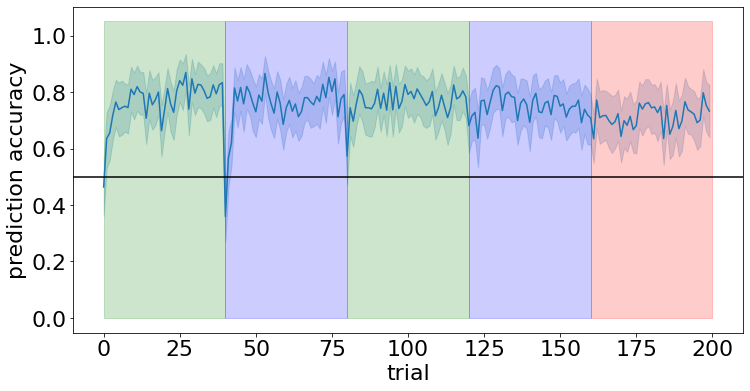

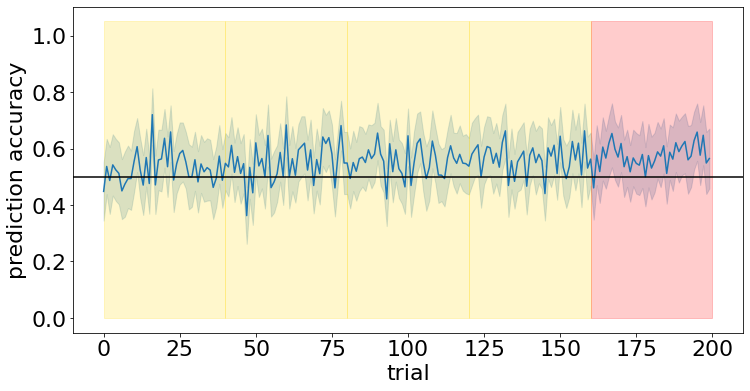

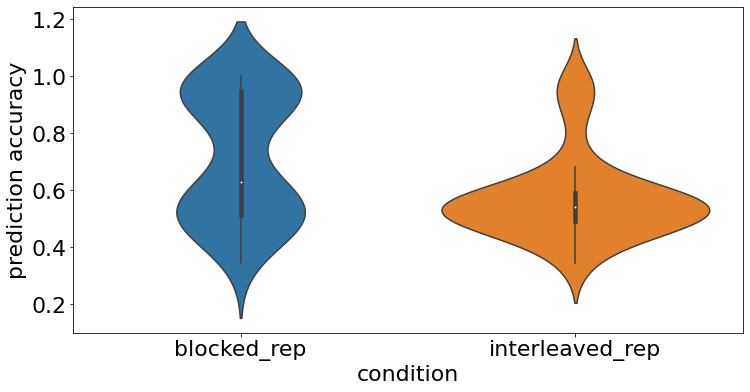

In [175]:
lineplt(['blocked_rep','interleaved_rep'],0)
beetestplt(['blocked_rep','interleaved_rep'],0)

# Figure S4 a-c

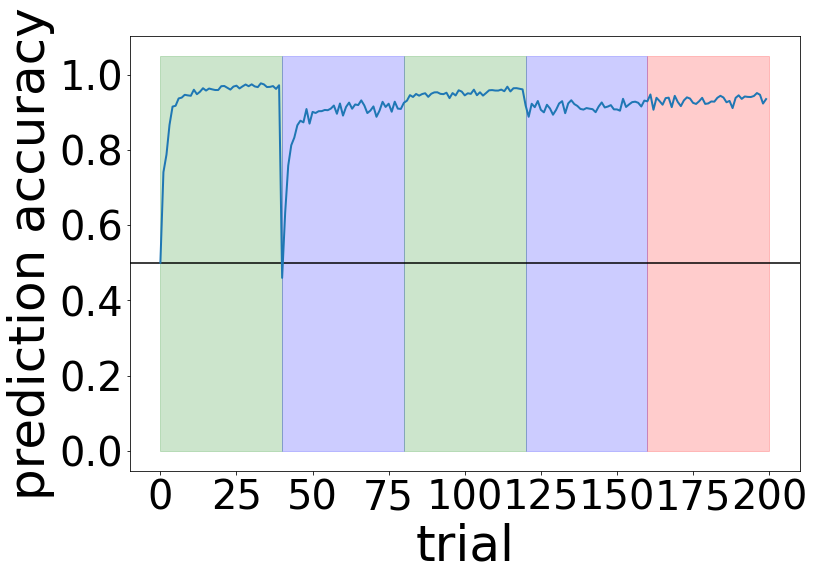

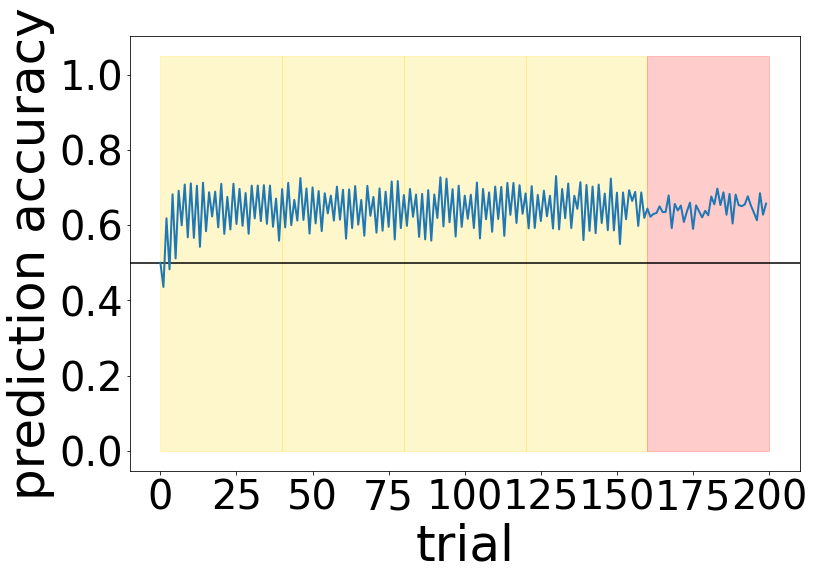

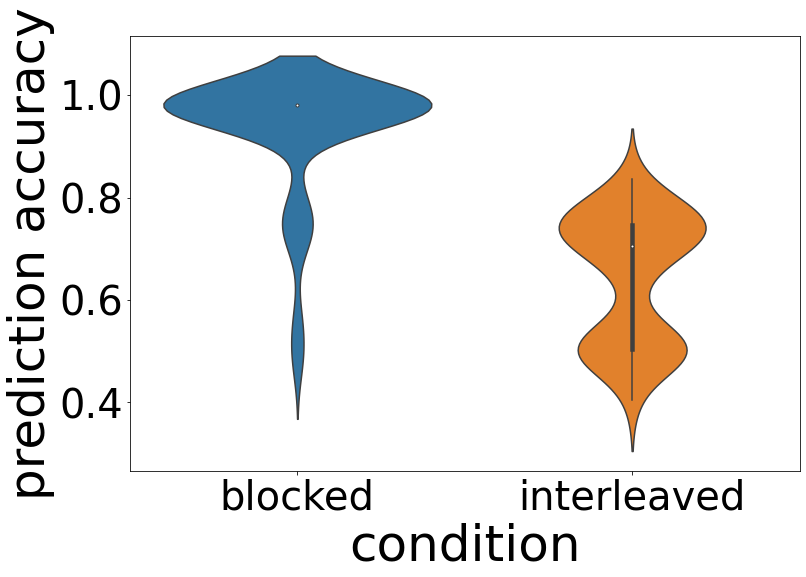

In [176]:
lineplot_modelBI("sim4")
beeswarm_modelBI("sim4")

# Figure S4 d-f

Unnamed: 0.2          int64
Unnamed: 0.1        float64
Unnamed: 0          float64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object
Unnamed: 0.2          int64
Unnamed: 0.1        float64
Unnamed: 0          float64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object


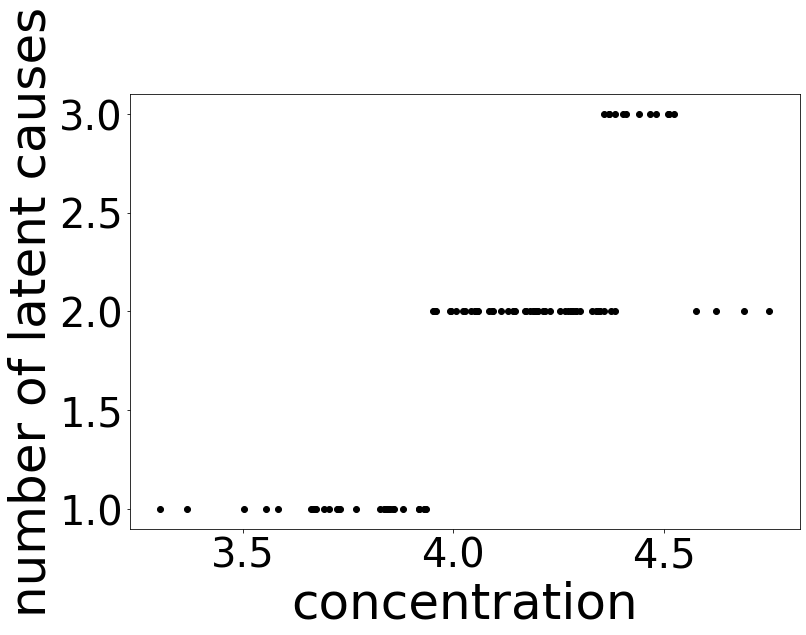

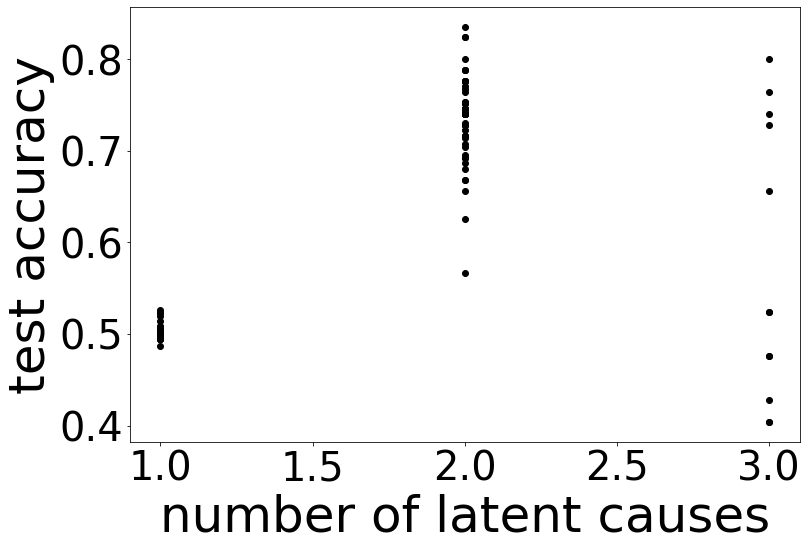

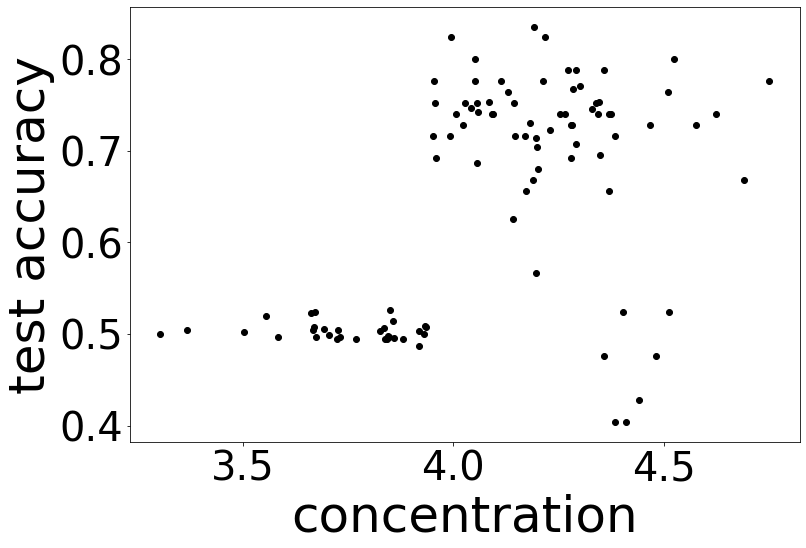

In [177]:
scatter_varied_parameter_vs_numlc("sim4", varied_parameter_name= "concentration")
scatter_numlc_vs_acc("sim4")
scatter_varied_parameter_vs_acc("sim4", varied_parameter_name= "concentration")

# Figure S4 g-j

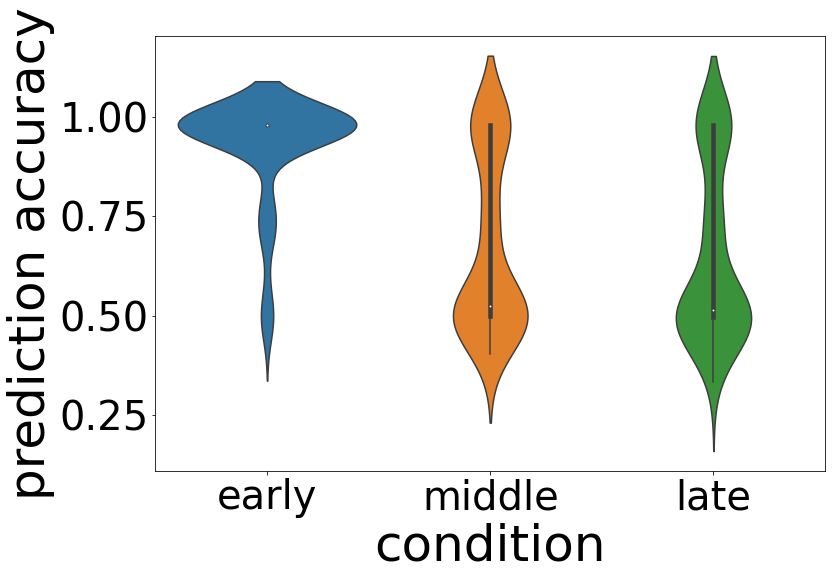

In [178]:
gsname="sim4"
#lineplot_modelEML(gsname)
beeswarm_modelEML(gsname) 

# Supplementary Figure 5: overlay human data and simulation 2

[0.9]
[0.9]


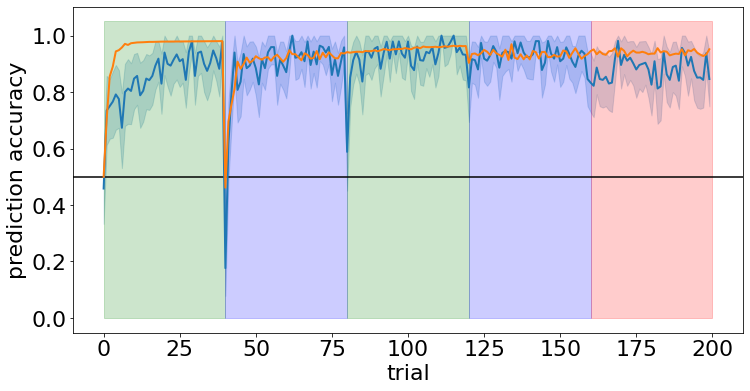

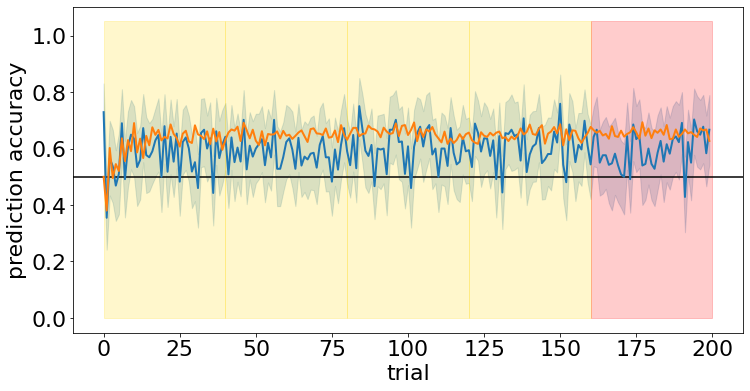

In [179]:
def get_human_trial_accuracy_df(cond,thresh,transition=None,ax=None,fgkw={},figname="none"):
  condL=[cond]
  df_plt = human_df.query("condition==@condL&thresh==@thresh").reset_index()
  print(df_plt.thresh.unique())
  if transition:
    assert transition in [1,2]
    df_plt = df_plt.query(f"depth=={transition}")
  return df_plt

gsname = "sim2"
for ix, condition in enumerate(['blocked','interleaved']):

    df_human_plt = get_human_trial_accuracy_df(cond = condition, thresh = 0.9)
    condstr=f'cond_int=={ix}'
    df_model_plt = model_acc_df.query(f"gs=='{gsname}'&{condstr}"
                  ).groupby(['trial','cond']).mean().reset_index()
    df_combined = {"human_or_model": ["human" for x in range(len(df_human_plt.story.tolist()))] + \
                                      ["model" for x in range(len(df_model_plt.trial.tolist()))] ,
                    "trial": df_human_plt.story.tolist() + df_model_plt.trial.tolist(),
                      "acc": df_human_plt.score.tolist() +  df_model_plt.acc.tolist()}

    plt.figure(figsize=(12,6))
    ax = plt.gca()
    ax.axhline(0.5,c='k')
    sns.lineplot(x = "trial", y = "acc", hue = "human_or_model", data = df_combined, legend = False,ax=ax, linewidth = 2)
    ax.set_xticks([0,25,50,75,100,125,150,175,200]) 
    ax.set_yticks([0.0, 0.2,0.4,0.6,0.8,1.0])
    ax.set_ylabel('prediction accuracy')
    color_background(ax,condition)


# Supplementary Figure 6: Latent Causes

In [180]:
exact_figure_latent_cause = False
if exact_figure_latent_cause:
    r = requests.get('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/supplementary_lc_dict.json')
    supplementary_lc_dict = r.json()
    transition_matrices_each_condition = supplementary_lc_dict["transition_matrices_each_condition"]
    for i in range(len(transition_matrices_each_condition)):
        for j in range(len(transition_matrices_each_condition[i])):
            for k in range(len(transition_matrices_each_condition[i][j])):
                transition_matrices_each_condition[i][j][k] = np.array(transition_matrices_each_condition[i][j][k])
    nschemas_each_condition = supplementary_lc_dict["nschemas_each_condition"]
else:
    np.random.seed(2)
    random.seed(2)
    # Opening JSON file
    r = requests.get('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sim_to_args.json')
    sim_to_args = r.json()
    sim_name = "sim3"
    args = sim_to_args[sim_name]
    paramstr = get_param_str_from_args(args)
    ns = 1000
    concentration_sd = 0.3
    concentration_lb = 0
    concentration_ub = np.inf
    concentration_mean = args["sch"]["concentration"]
    concentration_info = {
        'concentration_mean': concentration_mean,
        'concentration_sd': concentration_sd,
        'concentration_lb': concentration_lb,
        'concentration_ub': concentration_ub
    }
    (exp_batch_data, concentrationValue_each_seed,stickinessValue_each_seed,sparsityValue_each_seed, transition_matrices_each_condition, nschemas_each_condition)  = run_batch_exp_curr(ns,args,currL = ["blocked", "interleaved", "early", "middle", "late"], \
                                                                                                                        concentration_info = concentration_info, transition_matrix_analysis=True)



blocked
interleaved
early
middle
late


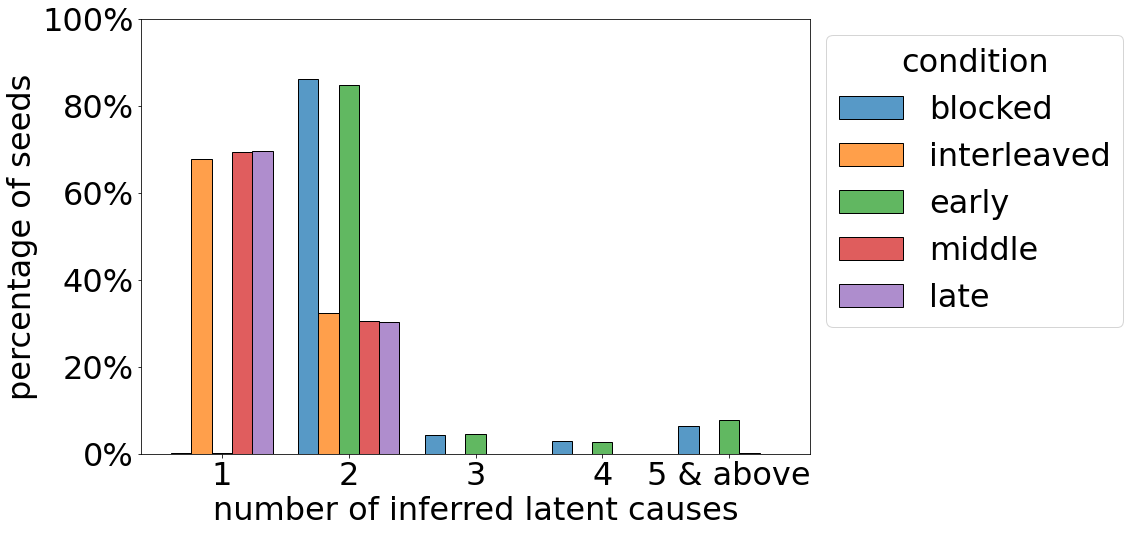

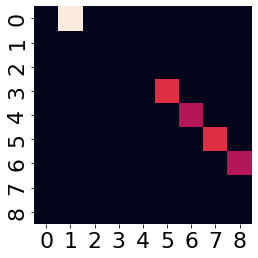

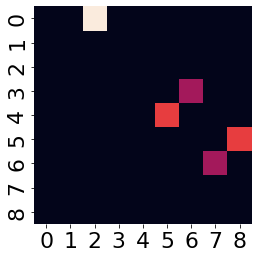

<AxesSubplot:>

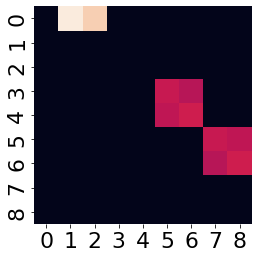

In [181]:
# nake plots a, b, c
# plot percentage of seeds in each latent cause quantity histogram
condition_list = []
nschemas_list = []
for i,cond in enumerate(["blocked", "interleaved", "early", "middle", "late"]):
    print(cond)
    for s in range(len(nschemas_each_condition[0])):
        condition_list.append(cond)
        if nschemas_each_condition[i][s] > 5:
            nschemas_list.append(5)
        else:
            nschemas_list.append(nschemas_each_condition[i][s])
plt.figure(figsize=(12,8))
ax = plt.gca()
df = pd.DataFrame({"condition": condition_list, "nschemas": nschemas_list})
ax = sns.histplot(data=df, \
                x="nschemas", hue="condition" , multiple="dodge", \
                discrete=True, shrink=.8, legend= True)

fsize = 32
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize = fsize)
plt.setp(ax.get_legend().get_title(), fontsize='32')  

ax.set_xlabel("number of inferred latent causes", fontsize = fsize)
ax.set_ylabel("percentage of seeds", fontsize = fsize)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(["1","2","3","4","5 & above"], fontsize = fsize)
ax.set_yticks([0,200,400,600,800,1000])
ax.set_yticklabels(["0%", "20%","40%","60%","80%", "100%"], fontsize = fsize)
plt.show()
# plot example of 2 latent causes
condition_select = 0
seed_select = nschemas_each_condition[condition_select].index(2)
Tmats_this_seed = transition_matrices_each_condition[condition_select][seed_select]
schema1 = Tmats_this_seed[0]
schema2 = Tmats_this_seed[1]
ax = sns.heatmap(schema1, xticklabels= [x for x in range(9)], yticklabels=[x for x in range(9)], cbar = False, square= True)
plt.show()
sns.heatmap(schema2, xticklabels= [x for x in range(9)], yticklabels=[x for x in range(9)], cbar = False, square= True)
plt.show()
# 1 latent cause example
condition_select = 1
seed_select = nschemas_each_condition[condition_select].index(1)
Tmats_this_seed = transition_matrices_each_condition[condition_select][seed_select]
schema1 = Tmats_this_seed[0]
sns.heatmap(schema1, xticklabels= [x for x in range(9)], yticklabels=[x for x in range(9)], cbar = False, square=True)

# Supplementary Figure 7: varying Stickiness

Unnamed: 0.2          int64
Unnamed: 0.1        float64
Unnamed: 0          float64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object
Unnamed: 0.2          int64
Unnamed: 0.1        float64
Unnamed: 0          float64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object


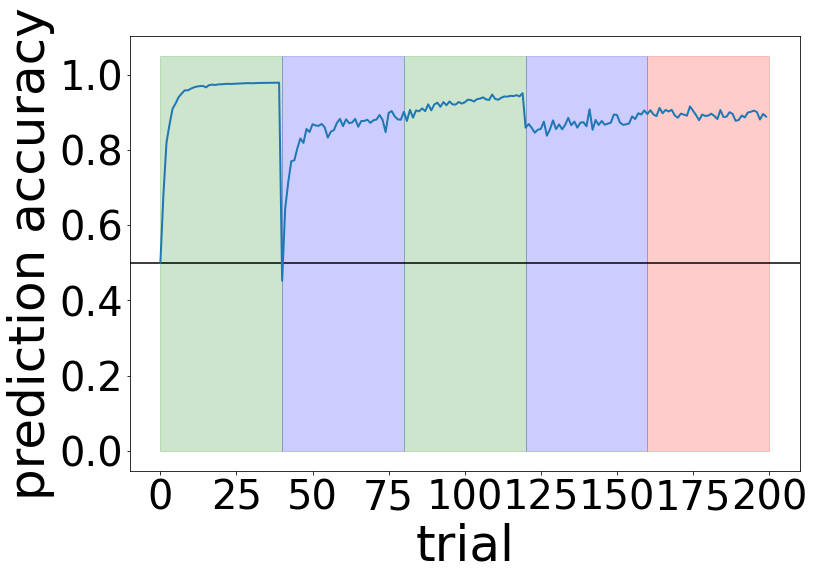

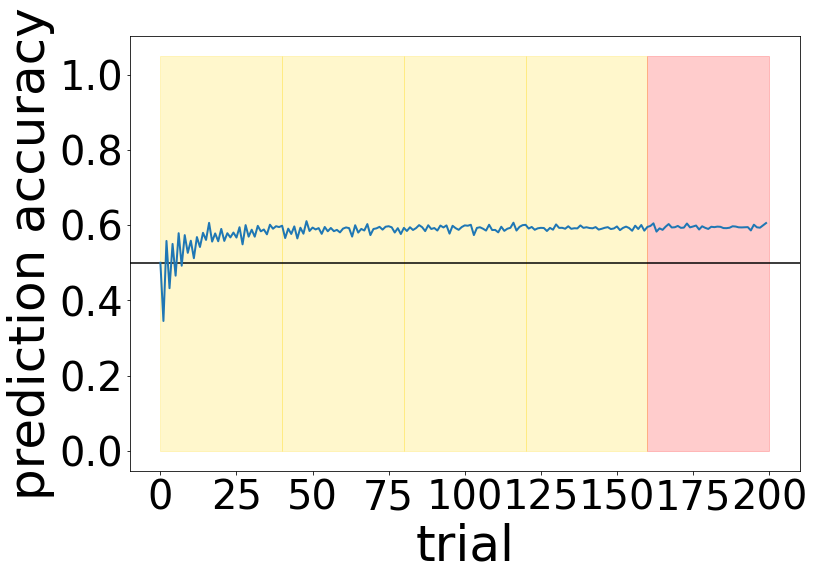

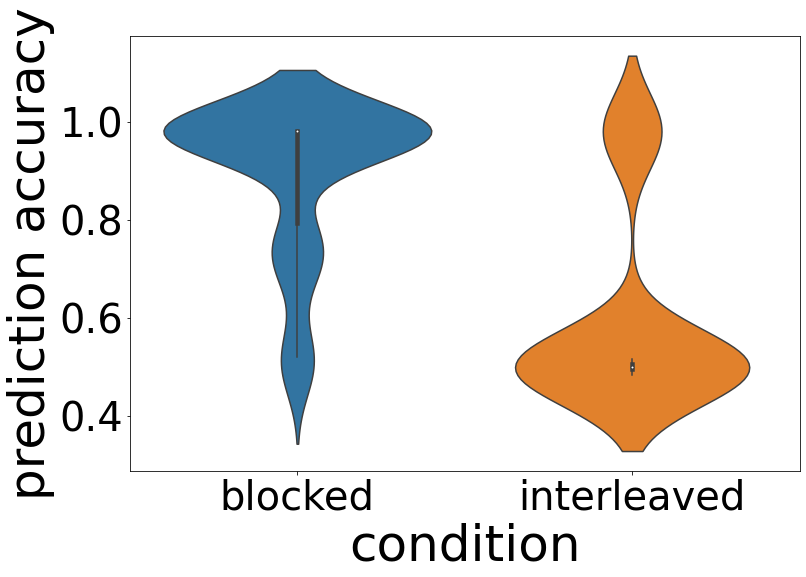

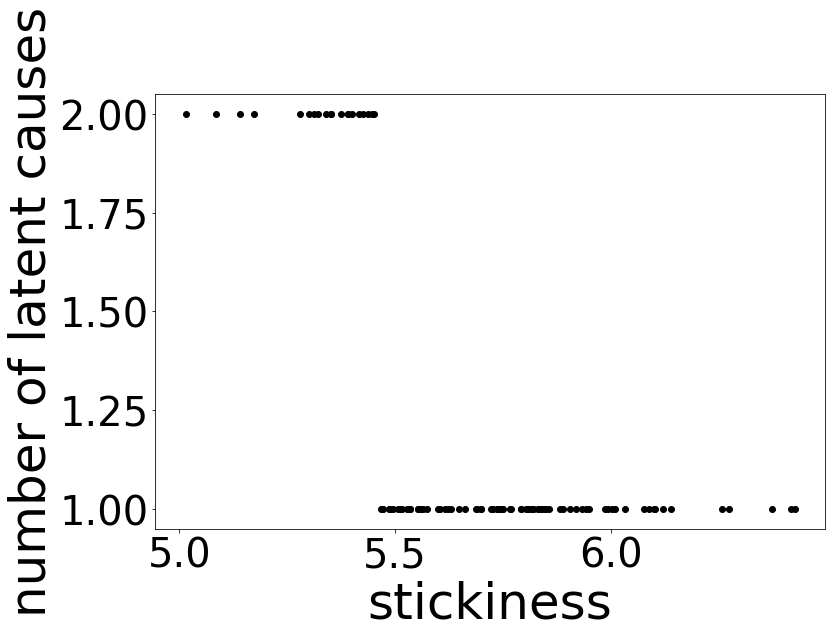

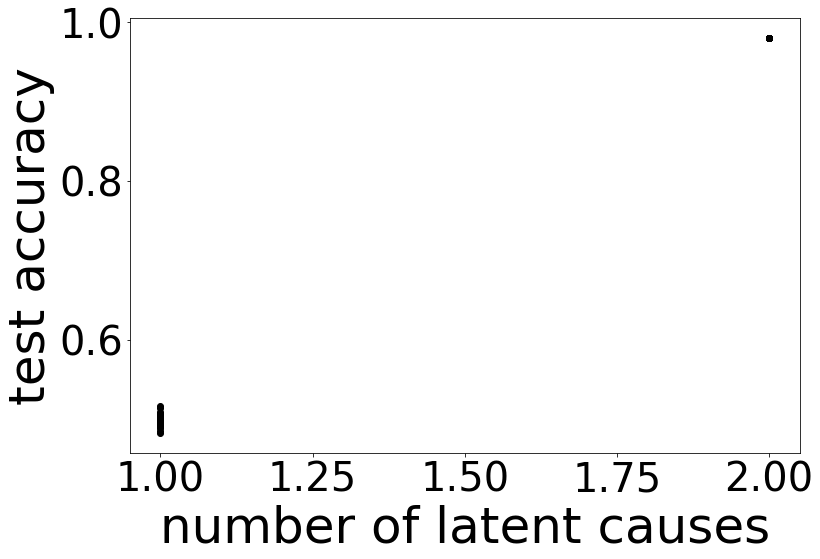

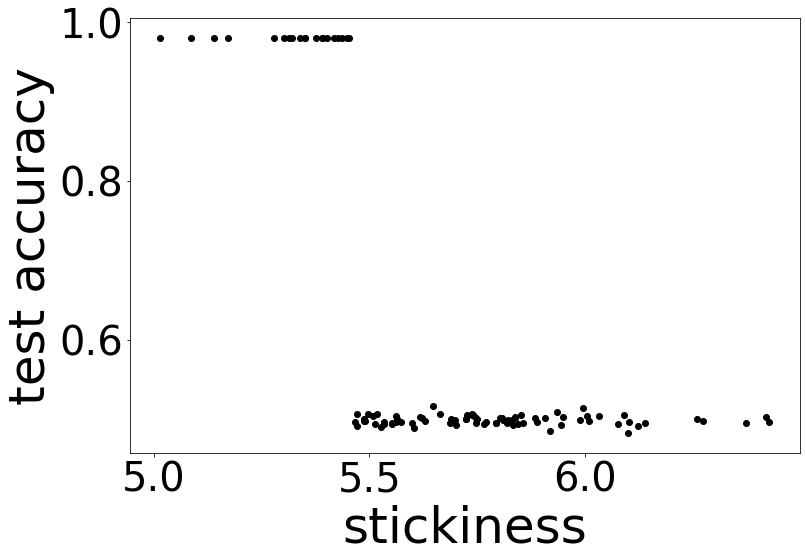

In [182]:
gsname="sim5"
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)
scatter_varied_parameter_vs_numlc(gsname, varied_parameter_name= "stickiness")
scatter_numlc_vs_acc(gsname)
scatter_varied_parameter_vs_acc(gsname, varied_parameter_name= "stickiness")

# Supplementary Figure 8: varying Sparsity

Unnamed: 0.2          int64
Unnamed: 0.1        float64
Unnamed: 0          float64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object
Unnamed: 0.2          int64
Unnamed: 0.1        float64
Unnamed: 0          float64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object


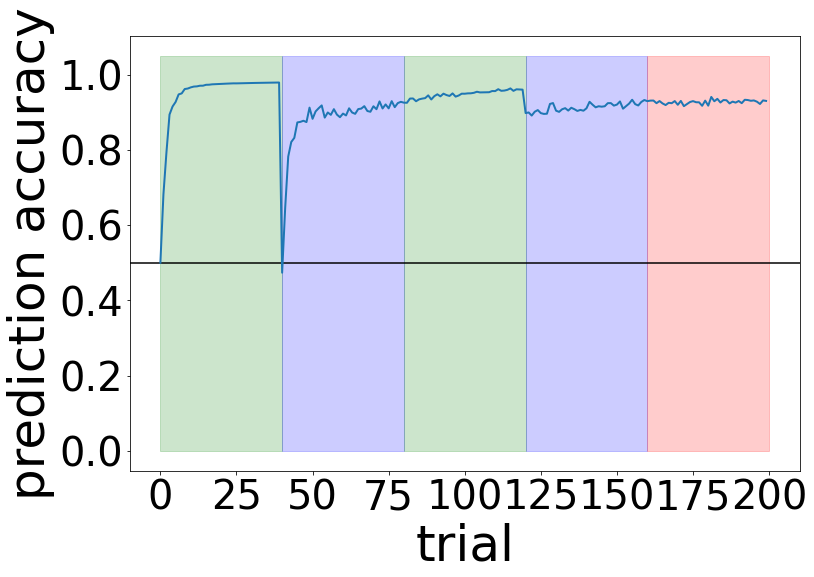

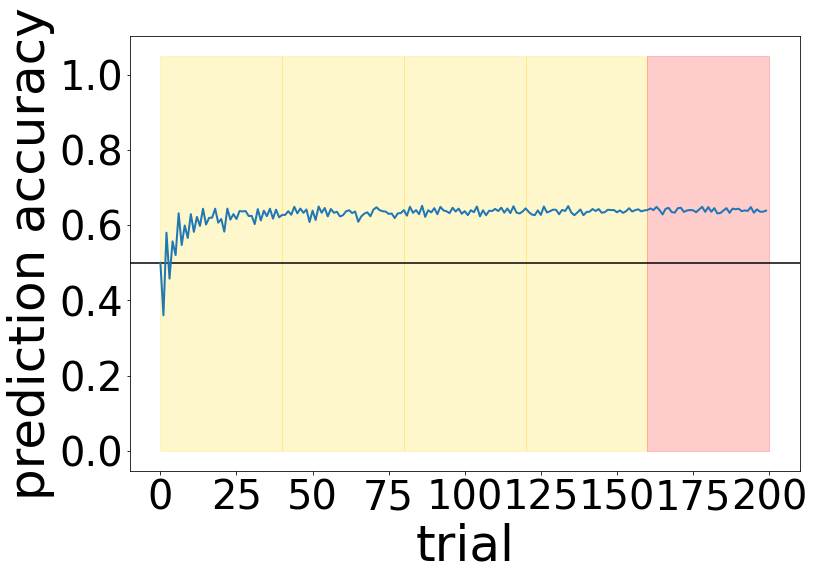

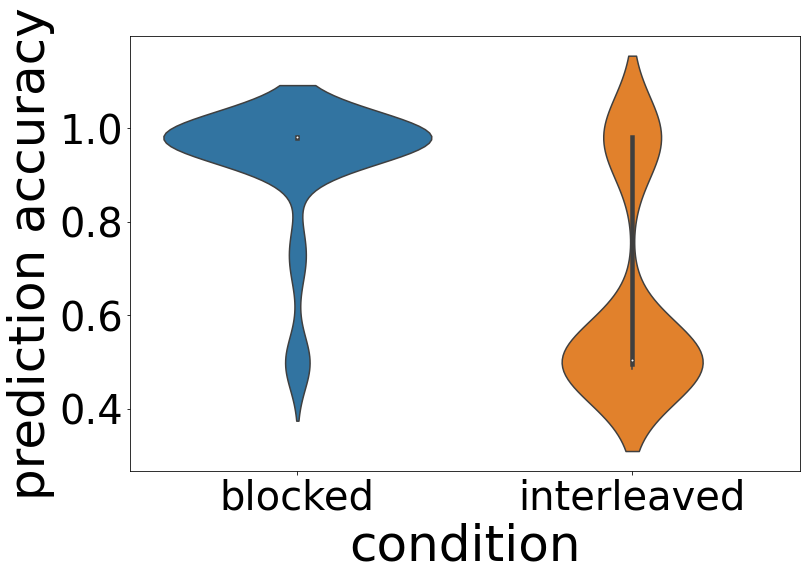

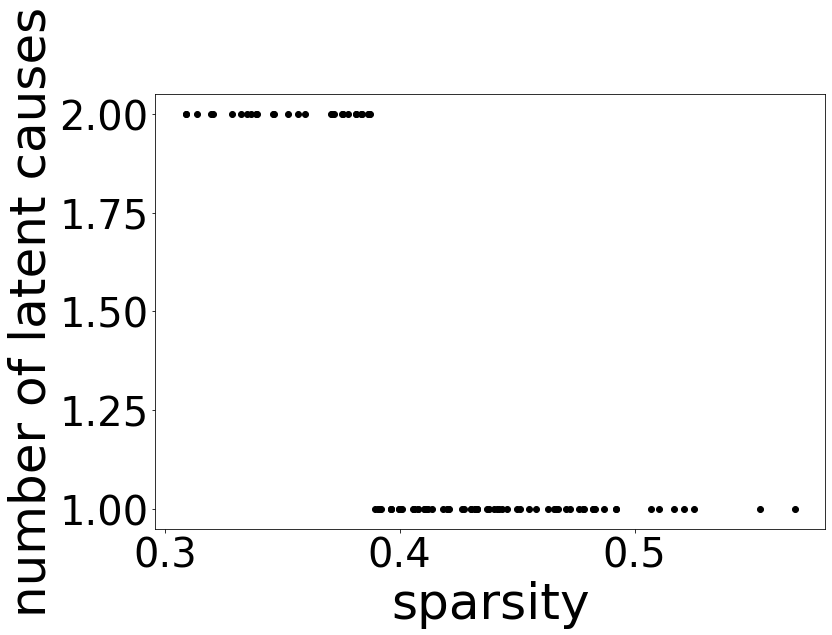

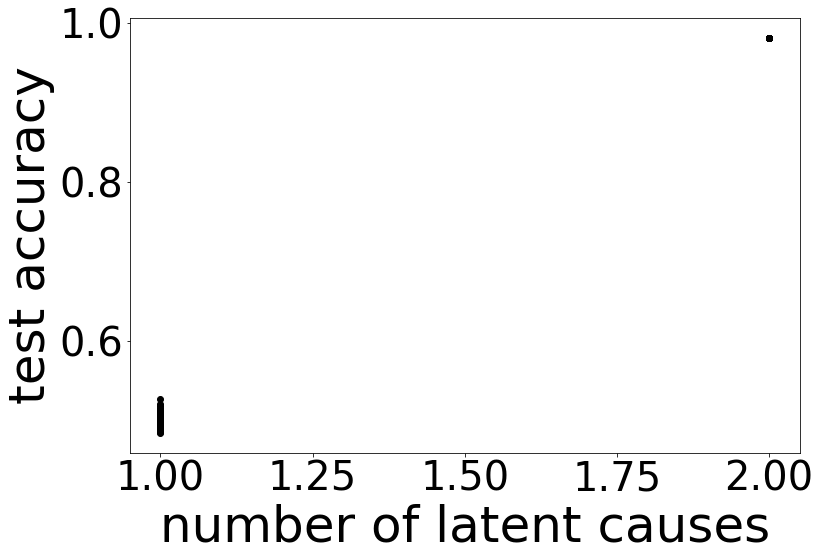

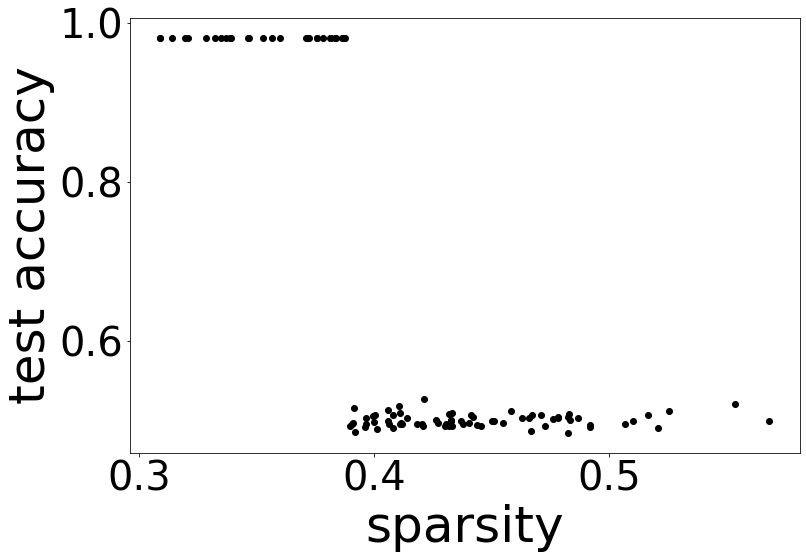

In [183]:
gsname="sim6"
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)
scatter_varied_parameter_vs_numlc(gsname, varied_parameter_name= "sparsity")
scatter_numlc_vs_acc(gsname)
scatter_varied_parameter_vs_acc(gsname, varied_parameter_name= "sparsity")

# Supplementary Figure 9: Bayes-optimal posterior predictive distribution

Unnamed: 0            int64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object
Unnamed: 0            int64
gs                   string
varied_parameter    float64
cond                 string
seed                  int64
trial                 int64
tstep                 int64
exp                   int64
zt                  float64
xth                   int64
cond_int              int32
dtype: object


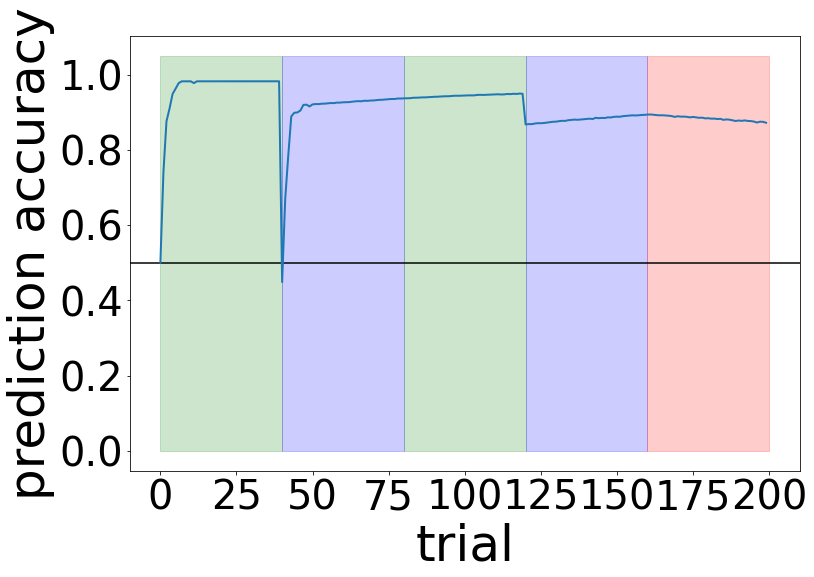

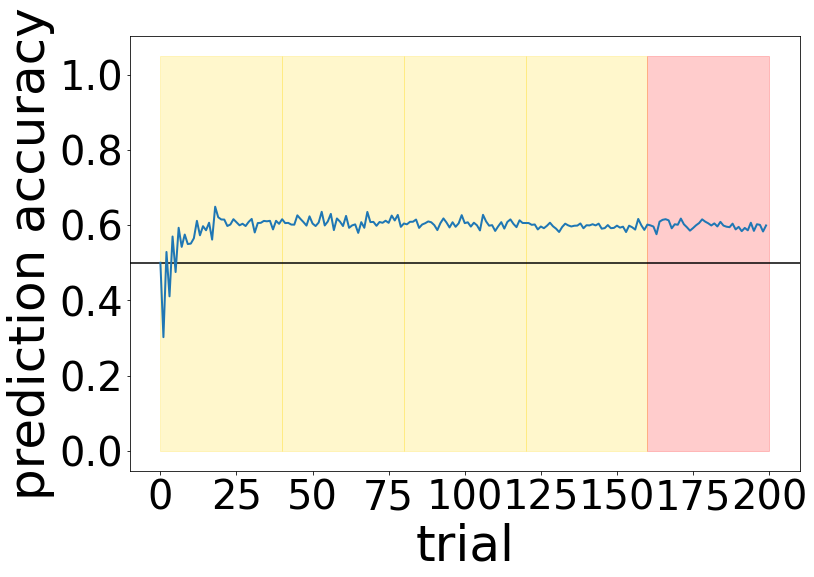

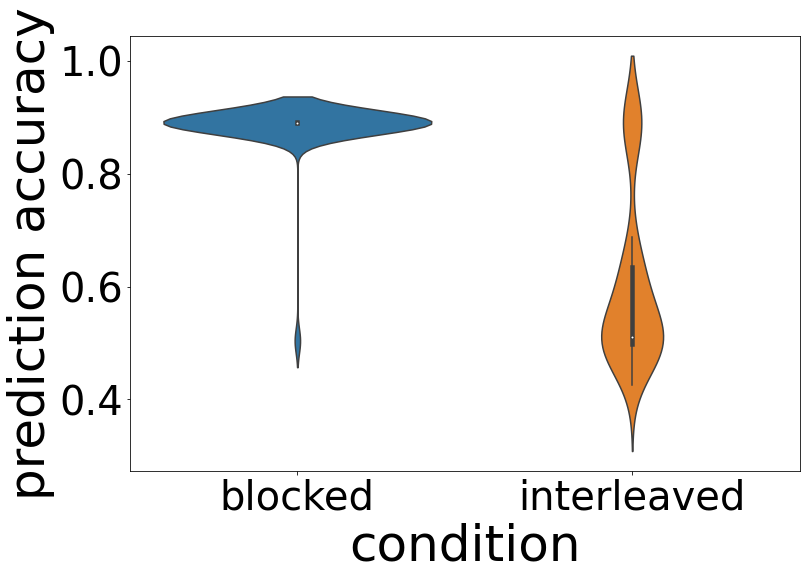

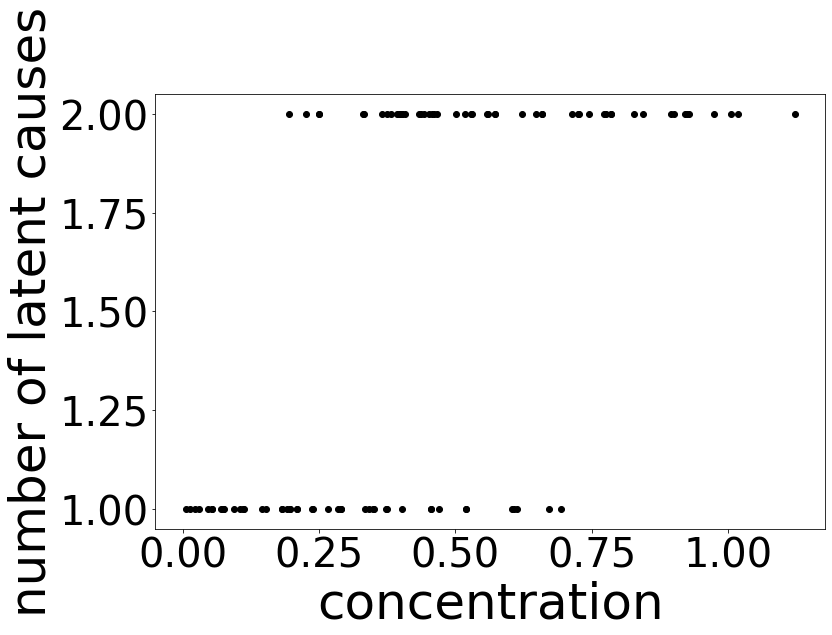

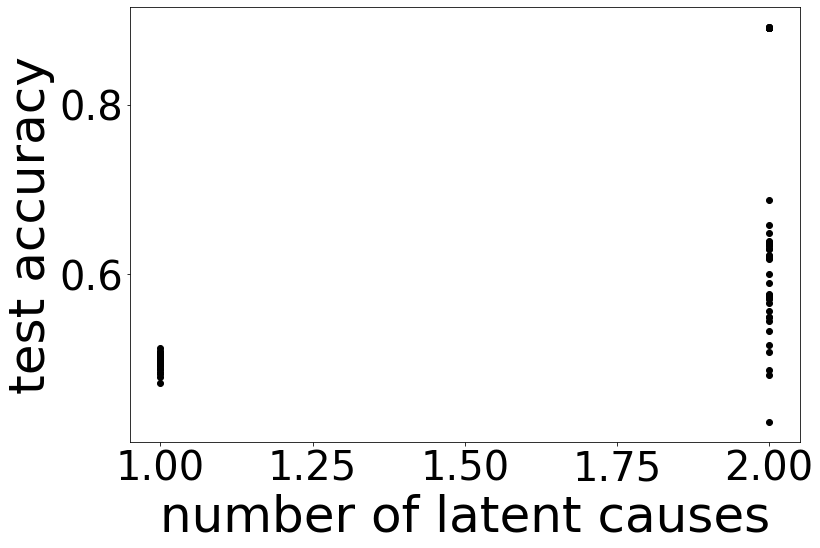

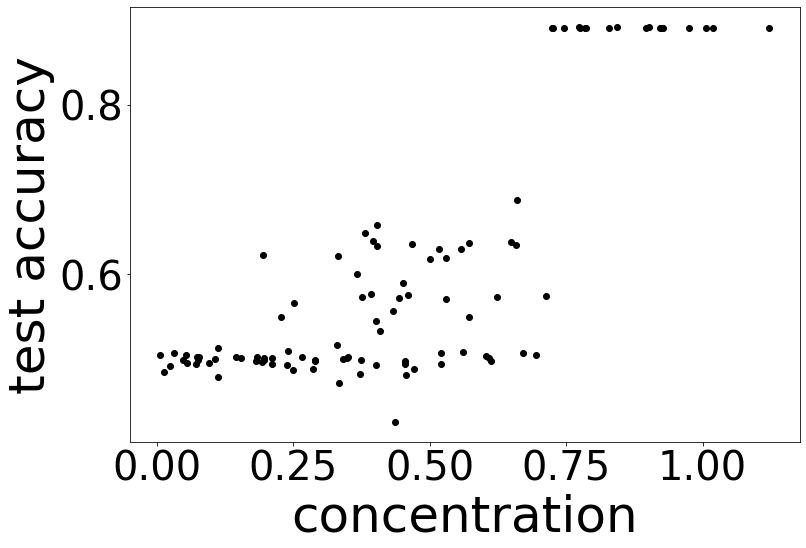

In [184]:
gsname="sim7"
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)
scatter_varied_parameter_vs_numlc("sim7", varied_parameter_name= "concentration")
scatter_numlc_vs_acc("sim7")
scatter_varied_parameter_vs_acc("sim7", varied_parameter_name= "concentration")

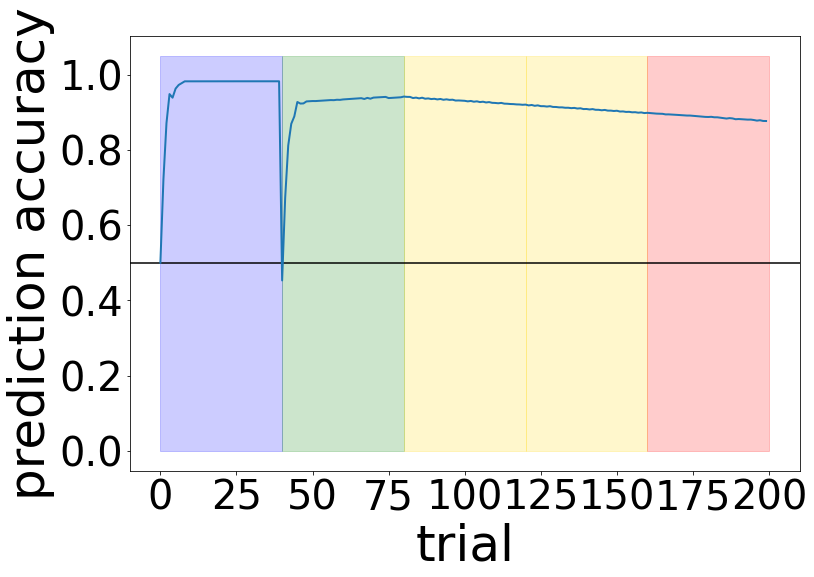

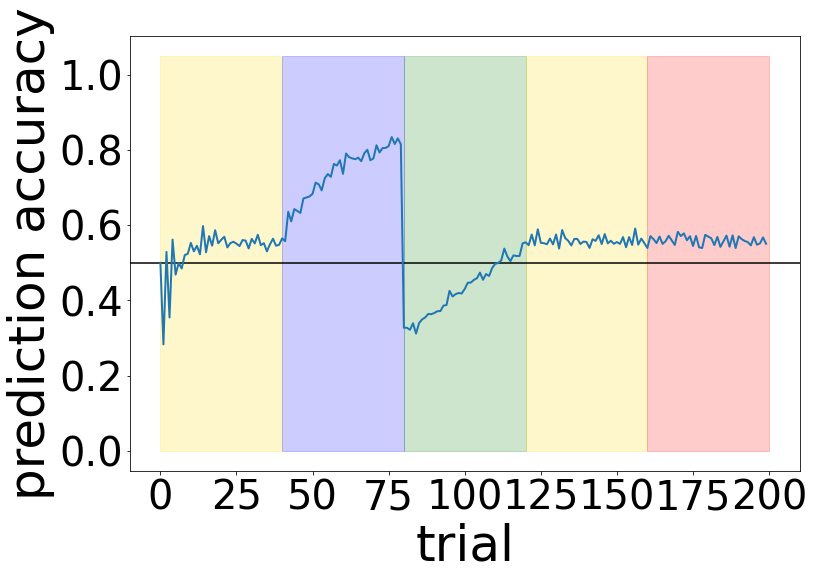

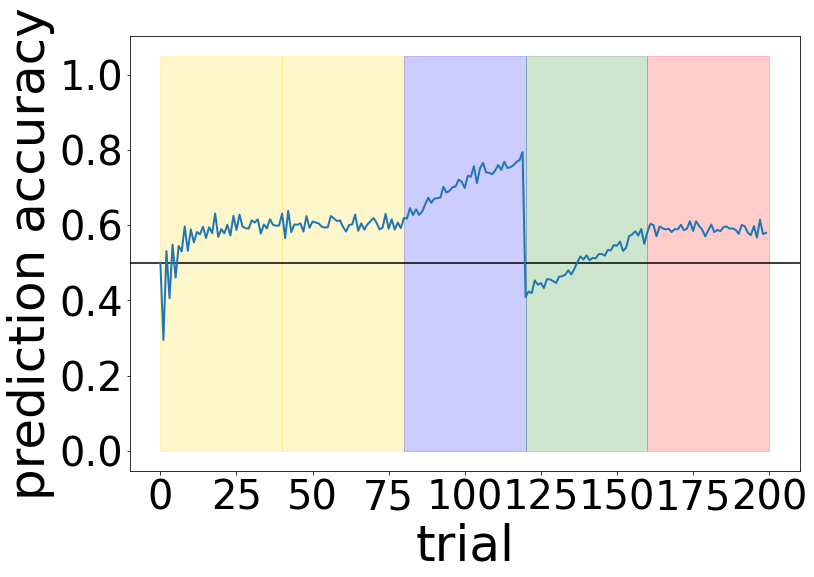

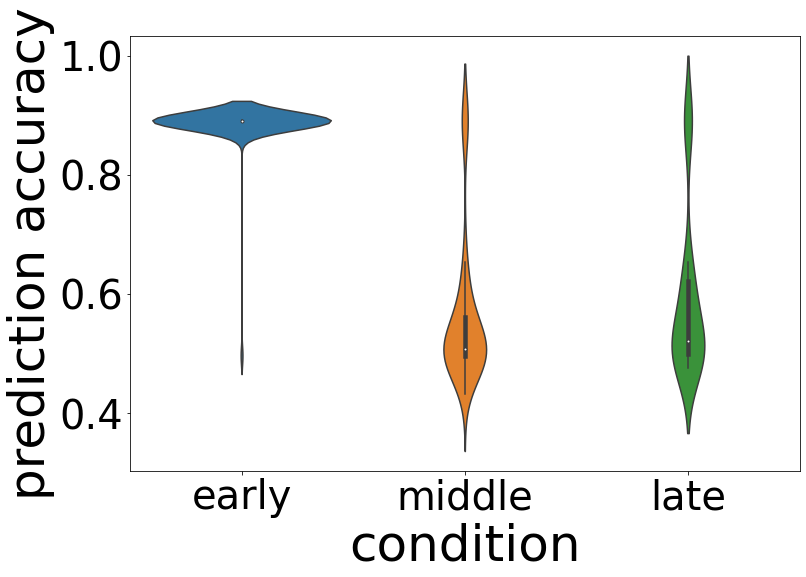

In [185]:
gsname="sim7"
lineplot_modelEML(gsname)
beeswarm_modelEML(gsname)